# Import packages

In [2]:
import rpy2
%load_ext rpy2.ipython
import GEOparse
import pandas as pd
import seaborn as sns
import re
import plotly.express as px
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [2]:
gse = GEOparse.get_GEO(geo="GSE99580", destdir="./preprocessed_data/")

01-Sep-2023 17:57:16 INFO GEOparse - Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE99nnn/GSE99580/soft/GSE99580_family.soft.gz to ./preprocessed_data/GSE99580_family.soft.gz
100%|██████████| 42.0M/42.0M [00:29<00:00, 1.48MB/s]
01-Sep-2023 17:57:48 DEBUG downloader - Size validation passed
01-Sep-2023 17:57:48 DEBUG downloader - Moving /var/folders/6t/jky9cnrn65x9gfpghzmvfpqh0000gp/T/tmprnlq7pav to /Users/fernando/Documents/Research/DRACOONpy/validation/real_data_bone_healing/preprocessed_data/GSE99580_family.soft.gz
01-Sep-2023 17:57:48 DEBUG downloader - Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE99nnn/GSE99580/soft/GSE99580_family.soft.gz
01-Sep-2023 17:57:48 INFO GEOparse - Parsing ./preprocessed_data/GSE99580_family.soft.gz: 
01-Sep-2023 17:57:48 DEBUG GEOparse - DATABASE: GeoMiame
01-Sep-2023 17:57:48 DEBUG GEOparse - SERIES: GSE99580
01-Sep-2023 17:57:48 DEBUG GEOparse - PLATFORM: GPL19485
01-Sep-2023 17:57:48 DEBUG GEOparse - SAMPLE: GSM2647787
01-Se

In [3]:
phenodata = gse.phenotype_data
phenodata = phenodata.reset_index()
phenodata

,index,title,geo_accession,status,submission_date,last_update_date,type,channel_count,source_name_ch1,organism_ch1,...,contact_department,contact_institute,contact_address,contact_city,contact_state,contact_zip/postal_code,contact_country,supplementary_file,series_id,data_row_count
0,GSM2647787,"AJ control d0 #2, batch A",GSM2647787,Public on Dec 25 2018,Jun 01 2017,Jun 25 2019,RNA,1,Control femur bone,Mus musculus,...,Microarray and Sequencing Resource,Boston University,"72 East Concord Street, E631",Boston,MA,02118,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2647...,GSE99580,21187
1,GSM2647788,"AJ control d5 #3, batch A",GSM2647788,Public on Dec 25 2018,Jun 01 2017,Jun 25 2019,RNA,1,Femur bone following experimental fracture,Mus musculus,...,Microarray and Sequencing Resource,Boston University,"72 East Concord Street, E631",Boston,MA,02118,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2647...,GSE99580,21187
2,GSM2647789,"AJ control d7 #3, batch A",GSM2647789,Public on Dec 25 2018,Jun 01 2017,Jun 25 2019,RNA,1,Femur bone following experimental fracture,Mus musculus,...,Microarray and Sequencing Resource,Boston University,"72 East Concord Street, E631",Boston,MA,02118,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2647...,GSE99580,21187
3,GSM2647790,"AJ control d10 #3, batch A",GSM2647790,Public on Dec 25 2018,Jun 01 2017,Jun 25 2019,RNA,1,Femur bone following experimental fracture,Mus musculus,...,Microarray and Sequencing Resource,Boston University,"72 East Concord Street, E631",Boston,MA,02118,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2647...,GSE99580,21187
4,GSM2647791,"AJ control d14 #3, batch A",GSM2647791,Public on Dec 25 2018,Jun 01 2017,Jun 25 2019,RNA,1,Femur bone following experimental fracture,Mus musculus,...,Microarray and Sequencing Resource,Boston University,"72 East Concord Street, E631",Boston,MA,02118,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2647...,GSE99580,21187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,GSM2648021,"B6 Pi[-] d14 #3, batch E",GSM2648021,Public on Dec 25 2018,Jun 01 2017,Jun 25 2019,RNA,1,Femur bone following experimental fracture,Mus musculus,...,Microarray and Sequencing Resource,Boston University,"72 East Concord Street, E631",Boston,MA,02118,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2648...,GSE99580,21187
235,GSM2648022,"B6 Pi[-] d18 #3, batch E",GSM2648022,Public on Dec 25 2018,Jun 01 2017,Jun 25 2019,RNA,1,Femur bone following experimental fracture,Mus musculus,...,Microarray and Sequencing Resource,Boston University,"72 East Concord Street, E631",Boston,MA,02118,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2648...,GSE99580,21187
236,GSM2648023,"B6 Pi[-] d21 #2, batch E",GSM2648023,Public on Dec 25 2018,Jun 01 2017,Jun 25 2019,RNA,1,Femur bone following experimental fracture,Mus musculus,...,Microarray and Sequencing Resource,Boston University,"72 East Concord Street, E631",Boston,MA,02118,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2648...,GSE99580,21187
237,GSM2648024,"B6 Pi[-] d28 #2, batch E",GSM2648024,Public on Dec 25 2018,Jun 01 2017,Jun 25 2019,RNA,1,Femur bone following experimental fracture,Mus musculus,...,Microarray and Sequencing Resource,Boston University,"72 East Concord Street, E631",Boston,MA,02118,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2648...,GSE99580,21187


In [5]:
fig = px.parallel_categories(phenodata, dimensions=['characteristics_ch1.0.tissue', 'characteristics_ch1.4.diet', 'characteristics_ch1.5.timepoint'])
fig

# Motivation: Differences in healing stages upon bone fracture

We could use Dracoon to see differences upon bone healing in normal conditions (no Pi-low diet). For this:
- We assume mouse strains have little/no effect on bone healing
- We compare:
    - Control samples (controlateral bone) from day 0 vs. every day so we obtain day-specific networks that explain the callus evolution.
    - Individual days vs. individual days, so we obtain the differential network that explains the transition from day 0, to 3, 3 to 5 etc.



In [6]:
# Step: Keep rows where characteristics_ch1.4.diet contains ontrol (not case-sensitive)
pheno2 = phenodata.loc[phenodata['characteristics_ch1.4.diet'].str.contains('ontrol', case=False, regex=False, na=False)]
pheno2 = pheno2.reset_index()
pheno2

,level_0,index,title,geo_accession,status,submission_date,last_update_date,type,channel_count,source_name_ch1,...,contact_department,contact_institute,contact_address,contact_city,contact_state,contact_zip/postal_code,contact_country,supplementary_file,series_id,data_row_count
0,0,GSM2647787,"AJ control d0 #2, batch A",GSM2647787,Public on Dec 25 2018,Jun 01 2017,Jun 25 2019,RNA,1,Control femur bone,...,Microarray and Sequencing Resource,Boston University,"72 East Concord Street, E631",Boston,MA,02118,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2647...,GSE99580,21187
1,1,GSM2647788,"AJ control d5 #3, batch A",GSM2647788,Public on Dec 25 2018,Jun 01 2017,Jun 25 2019,RNA,1,Femur bone following experimental fracture,...,Microarray and Sequencing Resource,Boston University,"72 East Concord Street, E631",Boston,MA,02118,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2647...,GSE99580,21187
2,2,GSM2647789,"AJ control d7 #3, batch A",GSM2647789,Public on Dec 25 2018,Jun 01 2017,Jun 25 2019,RNA,1,Femur bone following experimental fracture,...,Microarray and Sequencing Resource,Boston University,"72 East Concord Street, E631",Boston,MA,02118,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2647...,GSE99580,21187
3,3,GSM2647790,"AJ control d10 #3, batch A",GSM2647790,Public on Dec 25 2018,Jun 01 2017,Jun 25 2019,RNA,1,Femur bone following experimental fracture,...,Microarray and Sequencing Resource,Boston University,"72 East Concord Street, E631",Boston,MA,02118,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2647...,GSE99580,21187
4,4,GSM2647791,"AJ control d14 #3, batch A",GSM2647791,Public on Dec 25 2018,Jun 01 2017,Jun 25 2019,RNA,1,Femur bone following experimental fracture,...,Microarray and Sequencing Resource,Boston University,"72 East Concord Street, E631",Boston,MA,02118,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2647...,GSE99580,21187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,226,GSM2648013,"B6 control d10 #1, batch E",GSM2648013,Public on Dec 25 2018,Jun 01 2017,Jun 25 2019,RNA,1,Femur bone following experimental fracture,...,Microarray and Sequencing Resource,Boston University,"72 East Concord Street, E631",Boston,MA,02118,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2648...,GSE99580,21187
122,227,GSM2648014,"B6 control d14 #2, batch E",GSM2648014,Public on Dec 25 2018,Jun 01 2017,Jun 25 2019,RNA,1,Femur bone following experimental fracture,...,Microarray and Sequencing Resource,Boston University,"72 East Concord Street, E631",Boston,MA,02118,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2648...,GSE99580,21187
123,228,GSM2648015,"B6 control d21 #1, batch E",GSM2648015,Public on Dec 25 2018,Jun 01 2017,Jun 25 2019,RNA,1,Femur bone following experimental fracture,...,Microarray and Sequencing Resource,Boston University,"72 East Concord Street, E631",Boston,MA,02118,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2648...,GSE99580,21187
124,229,GSM2648016,"B6 control d28 #2, batch E",GSM2648016,Public on Dec 25 2018,Jun 01 2017,Jun 25 2019,RNA,1,Femur bone following experimental fracture,...,Microarray and Sequencing Resource,Boston University,"72 East Concord Street, E631",Boston,MA,02118,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2648...,GSE99580,21187


In [7]:
fig = px.parallel_categories(pheno2, dimensions=['characteristics_ch1.0.tissue', 'characteristics_ch1.5.timepoint'])
fig

```
%%bash
conda install -y -c bioconda bioconductor-org.mm.eg.db
conda install -y -c bioconda bioconductor-annotationdbi
conda install -y -c bioconda bioconductor-biobase
conda install -y -c bioconda bioconductor-limma
conda install -y -c r r-stringr
conda install -y -c conda-forge r-dplyr
conda install -y -c bioconda bioconductor-clusterprofiler
conda install -y -c bioconda bioconductor-enrichplot
conda install -y -c conda-forge r-ggplot2


# R preprocessing and basic DEA

In [23]:
samples_pheno2 = pheno2.geo_accession.to_list()
expr_pheno2 = gse.pivot_samples('VALUE')[samples_pheno2]

## Basic preprocessing and feature selection
Next we would like to filter out probes that are not expressed. The gene is expressed (in definition here) when its average log2 intensity in control samples is above 0.25 quantile. I.e. we filter out worst 25% genes.

In [24]:
expr_pheno2_average = expr_pheno2.median(axis=1)
print("Number of probes before filtering: ", len(expr_pheno2_average))

expression_threshold = expr_pheno2_average.quantile(0.25)

expressed_probes = expr_pheno2_average[expr_pheno2_average >= expression_threshold].index.tolist()
print("Number of probes above threshold: ", len(expressed_probes))

expr_pheno2_filtered = expr_pheno2.loc[expressed_probes]

Number of probes before filtering:  21187
Number of probes above threshold:  15890


We can see that the filtering succeeded. Now we filtered out probes that are not expressed. Nowe we map to the right annotations. 

In [25]:
affy2entrez = dict(zip(gse.gpls['GPL19485'].table['ID'], gse.gpls['GPL19485'].table['SPOT_ID'].astype(str)))
expr_pheno2_filtered.index = expr_pheno2_filtered.index.map(affy2entrez)
expr_pheno2_filtered = expr_pheno2_filtered.reset_index()
expr_pheno2_filtered

name,ID_REF,GSM2647787,GSM2647788,GSM2647789,GSM2647790,GSM2647791,GSM2647792,GSM2647793,GSM2647794,GSM2647795,...,GSM2648001,GSM2648009,GSM2648010,GSM2648011,GSM2648012,GSM2648013,GSM2648014,GSM2648015,GSM2648016,GSM2648017
0,100008567,5.758671,5.273934,5.638311,5.503928,5.526243,5.367219,5.603233,5.676425,5.559227,...,5.716038,5.711937,5.742559,5.858003,5.766631,6.003751,5.776219,5.800096,5.725587,5.966962
1,100009600,4.833936,4.692619,4.500633,4.451974,4.686011,4.725178,4.567720,4.594533,4.636787,...,4.938868,5.076899,4.685547,4.700649,4.990006,4.808530,4.977418,4.702891,4.872207,4.981112
2,100009614,4.841795,5.085856,4.986482,5.103702,4.913735,5.027872,5.158753,5.094997,5.441100,...,5.363782,5.546011,5.414692,5.378324,5.500169,5.646955,5.554850,5.411926,5.352590,5.173812
3,100017,8.690023,8.612261,8.570286,8.709863,8.668344,8.518722,8.737408,8.571618,8.594450,...,8.799891,8.608835,8.616965,8.629680,8.849187,8.732479,8.949673,8.574374,8.685152,8.793800
4,100019,7.160633,7.239214,7.025828,7.024851,7.068829,7.157076,7.091912,7.059640,7.145658,...,6.941664,7.314025,7.348914,6.813329,6.806428,6.837216,6.799676,6.920272,7.087419,6.955190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15885,99889,6.701711,7.316525,7.756043,7.670965,7.624883,7.148673,6.975497,6.950896,6.695138,...,6.589495,6.845751,6.695045,7.356623,7.289545,7.562515,7.201816,6.861614,6.844151,6.746828
15886,99890,6.322740,6.321913,6.038020,6.348177,6.443174,6.168258,6.175297,6.345529,6.278599,...,6.135846,6.369284,6.312041,6.317063,6.137033,6.124574,6.283197,6.103187,6.221143,6.226143
15887,99899,7.122190,7.605287,8.506302,7.814214,7.775806,9.025373,7.472458,8.215246,7.547450,...,7.870302,6.820427,6.842444,5.974729,5.457094,6.987080,6.224221,6.185286,6.404399,6.115419
15888,99929,6.749403,6.844952,7.133987,7.099419,7.063616,6.882299,6.722683,6.712372,6.857983,...,6.523911,6.657311,6.898581,6.223876,6.136187,6.832264,6.551359,6.364854,6.853452,6.158595


What we have to do is for each time-point identify control and callus sample and subtract the VALUES (they are provided as log2 transformed already, we subtract callus from the control). In order to identify control and callus samples we will take a look into phenotype data and based on it we decide how to split samples.

In [26]:
experiments = {}
for i, (idx, row) in enumerate(pheno2.iterrows()):
    tmp = {}
    tmp["Experiment"] = row["geo_accession"] 
    tmp["Type"] = "callus" if "callus" in row["characteristics_ch1.0.tissue"] else "bone"
    tmp["Time"] = re.search(r"day (\d+)", row["characteristics_ch1.5.timepoint"]).group(1)
    experiments[i] = tmp
experiments = pd.DataFrame(experiments).T
experiments.Time = experiments.Time.astype(int)
experiments['Time'] = 'day_' + experiments['Time'].astype(str)

print(experiments)

     Experiment    Type    Time
0    GSM2647787    bone   day_0
1    GSM2647788  callus   day_5
2    GSM2647789  callus   day_7
3    GSM2647790  callus  day_10
4    GSM2647791  callus  day_14
..          ...     ...     ...
121  GSM2648013  callus  day_10
122  GSM2648014  callus  day_14
123  GSM2648015  callus  day_21
124  GSM2648016  callus  day_28
125  GSM2648017  callus  day_35

[126 rows x 3 columns]


Now we get which genes are we actually analyzing

In [27]:
%%R -i expr_pheno2_filtered -i pheno2 -i experiments
library(org.Mm.eg.db)
library(AnnotationDbi)
library(Biobase)
library(limma)
library(stringr)
library(dplyr)
library(RColorBrewer)
library(clusterProfiler)
library(enrichplot)
library(ggplot2)

rownames(expr_pheno2_filtered) <- expr_pheno2_filtered$ID_REF
expr_pheno2_filtered$ID_REF <- NULL
### Features data which contains gene names and symbols for each ensembl id (gene) -> DATAFRAME
features <- AnnotationDbi::select(org.Mm.eg.db, keys=rownames(expr_pheno2_filtered), columns=c("SYMBOL", "GENENAME"), keytype="ENTREZID")

rownames(features) <- features$ENTREZID
features$ENTREZID <- NULL
print(head(features))

           SYMBOL                                           GENENAME
100008567 Gm14964                               predicted gene 14964
100009600   Zglp1                   zinc finger, GATA-like protein 1
100009614 Gm10024                               predicted gene 10024
100017    Ldlrap1 low density lipoprotein receptor adaptor protein 1
100019       Mdn1                               midasin AAA ATPase 1
100034251  Wfdc17                  WAP four-disulfide core domain 17


'select()' returned 1:1 mapping between keys and columns


In [28]:
%%R
### Phenotype data which contains attributes for each sample -> DATAFRAME 
# pheno2[["characteristics_ch1.5.timepoint"]] = str_replace_all(pheno2[["characteristics_ch1.5.timepoint"]], ' ', '_')
experiments[["Time"]] <- as.factor(experiments[["Time"]])
print(levels(experiments[["Time"]]))

phenotypes <- experiments
rownames(phenotypes) <- phenotypes$Experiment
phenotypes$Experiments <- NULL

### Include expression data
exprs <- as.matrix(expr_pheno2_filtered)
eset <- ExpressionSet(assayData = exprs,
                      phenoData = AnnotatedDataFrame(phenotypes),
                      featureData = AnnotatedDataFrame(features))

 [1] "day_0"  "day_10" "day_14" "day_18" "day_21" "day_28" "day_3"  "day_35"
 [9] "day_5"  "day_7" 


## Basic DEA
We continue our analysis in R using the famous limma package. At this point, we should have processed ExpressionSet objects.

GSE99580 is an example of a factorial experimental design, in which covariates are varied in a single experiment. In this case, the tissue type is control (day 0) or bone callus (days 3-35) and the time points are varied (day 0, 3, 5, 7, 10, 13, 18, 21, 28, 35). We also have different mices (AJ, CH3 or B6). 

In order to model the expression of each gene, we can model the group mean expression under each condition. We have four conditions, so the model is something like:

$\hat{Y} = ϵ + \sum \limits _{j=1} ^{p} \hat{\beta}_{j}X_{j} $

where each value $\beta$ represents a particular condition. We would like to identify genes where othe contrasts represent changes between different groups, i.e., the effect of time in each mice strain. In order to do that, we need to specify contrasts explicitly. One way to do this is to create a “dummy” variable that represents the four groups.

In [29]:
%%R
design <- model.matrix(~ 0 + eset[["Time"]])
colnames(design) <- levels(as.factor(eset[["Time"]]))
print(head(design))

contrasts_matrix <- makeContrasts(day_0 - day_3,  day_0 - day_5,  day_0 - day_7, day_0 - day_10, day_0 - day_14, day_0 - day_18, day_0 - day_21, day_0 - day_28, day_0 - day_35, 
levels=design)
print(head(contrasts_matrix))


  day_0 day_10 day_14 day_18 day_21 day_28 day_3 day_35 day_5 day_7
1     1      0      0      0      0      0     0      0     0     0
2     0      0      0      0      0      0     0      0     1     0
3     0      0      0      0      0      0     0      0     0     1
4     0      1      0      0      0      0     0      0     0     0
5     0      0      1      0      0      0     0      0     0     0
6     0      0      0      0      1      0     0      0     0     0
        Contrasts
Levels   day_0 - day_3 day_0 - day_5 day_0 - day_7 day_0 - day_10
  day_0              1             1             1              1
  day_10             0             0             0             -1
  day_14             0             0             0              0
  day_18             0             0             0              0
  day_21             0             0             0              0
  day_28             0             0             0              0
        Contrasts
Levels   day_0 - day_14 da

The lmFit() function of limma fits a linear model for every row of our expression matrix. In the case of a two-class comparison, this is equivalent to a simple t-test.

Empirical Bayes (eBayes) is a method that borrows information about the distribution across genes to calculate a robust test statistic. In limma, this can be performed using the eBayes() function. The function requires that we provide an object returned from fitting a linear model (or contrast matrix) to the data. Performing eBayes correction is easily done in R using the following line of code:

In [30]:
%%R
fit <- lmFit(eset, design)
fit2 <- contrasts.fit(fit, contrasts=contrasts_matrix)
fit2 <- eBayes(fit2)
summary(decideTests(fit2, lfc=2, adjust.method="fdr", p.value=0.01))

       day_0 - day_3 day_0 - day_5 day_0 - day_7 day_0 - day_10 day_0 - day_14
Down             374           438           503            483            364
NotSig         15364         15297         15130          15207          15479
Up               152           155           257            200             47
       day_0 - day_18 day_0 - day_21 day_0 - day_28 day_0 - day_35
Down              239             69             24             11
NotSig          15638          15821          15866          15879
Up                 13              0              0              0


In general, it takes approximately 3-4 weeks for a femur fracture to heal in mice. However, this can vary depending on the type of fracture and the healing response of the mouse. Some studies have reported complete healing of femur fractures in mice in as little as two weeks, while others have reported healing times of up to six weeks.

It's worth noting that the healing process can also be influenced by various factors such as diet, exercise, and medication. In addition, certain strains of mice may have different healing times due to genetic differences. Therefore, it's important to consider these variables when interpreting data related to femur fracture healing in mice.

Let's take a look at which functions are represented in our studied groups.

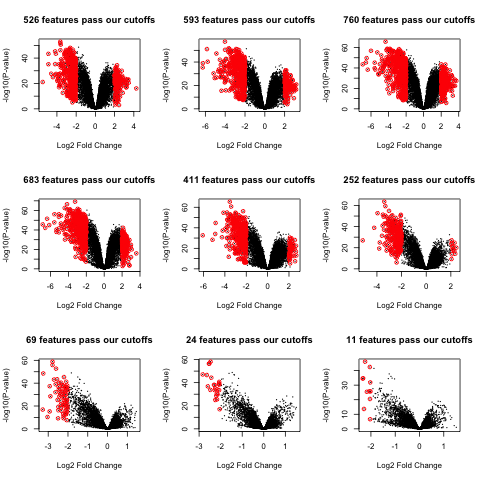

In [31]:
%%R
par(mfrow = c(3, 3)) # Create a 2 x 2 plotting matrix
for(x in 1:9){
    interesting_genes <- topTable(fit2, number=Inf, p.value = 0.01, lfc=2, coef=x)
    volcanoplot(fit2, coef=x, main=sprintf("%d features pass our cutoffs", nrow(interesting_genes)))
    points(interesting_genes[['logFC']],-log10(interesting_genes[['P.Value']]),col='red')
             }
   


From the Volcano plot above, we can see that many genes tend to show small but statistically insignificant changes in expression level between the two conditions. On the other hand, a small subset of the genes show very large fold changes with relatively small p-values. These “interesting” genes tend to be further analyzed for their potential role in the biological phenomenon of interest.


From the heatmap, we can see that the expression profile from day 0 clusters together with late healing days (day 18 ++), whereas early days after the surgery cluster together separately (days 3 - 14).

In addition: Warning message:
In brewer.pal(100, "RdBu") :
  n too large, allowed maximum for palette RdBu is 11
Returning the palette you asked for with that many colors



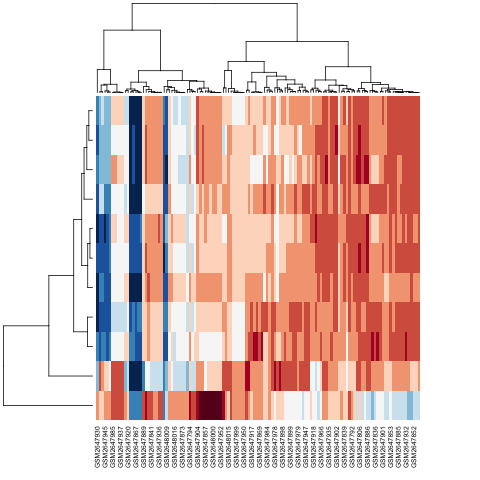

In [32]:
%%R
eset_of_interest <- eset[rownames(interesting_genes),]
heatmap(exprs(eset_of_interest),
        labCol=eset[['characteristics_ch1.5.timepoint']], labRow=NA,
        col       = rev(brewer.pal(100, "RdBu")),
        distfun   = function(x) as.dist(1-cor(t(x))))

## Basic Enrichment analysis
### GSEA

In [34]:
%%R
gsearesult <- data.frame()
for (x in 1:8){
    print(x)
    all_degsx <- topTable(fit2, number=Inf, p.value = 1, lfc=0, coef=x)
    filename = paste0(paste0("dea_per_timepoint/dea_",  colnames(contrasts_matrix)[x]), ".tsv")
    print(filename)
    write.table(all_degsx, filename, sep='\t', quote=F)

    interesting_genes <- topTable(fit2, number=Inf, p.value = 0.01, lfc=2, coef=x)
    # we want the log2 fold change 
    original_gene_list <- interesting_genes[['logFC']]
    # name the vector
    names(original_gene_list) <- rownames(interesting_genes)
    # omit any NA values 
    gene_list<-na.omit(original_gene_list)
    # sort the list in decreasing order (required for clusterProfiler)
    gene_list = sort(gene_list, decreasing = TRUE)

    print(length(original_gene_list))
    gse <- gseGO(geneList=gene_list, 
                 ont ="BP", 
                 keyType = "ENTREZID", 
                 nPerm = 10000, 
                 minGSSize = 3, 
                 maxGSSize = 800, 
                 pvalueCutoff = 0.05, 
                 verbose = TRUE, 
                 OrgDb = "org.Mm.eg.db", 
                 pAdjustMethod = "none")

    gseares <- data.frame(gse)
    gseares <- head(gseares[order(gseares$p.adjust, decreasing= F),], n = 10)
    gseares['comparison'] = colnames(contrasts_matrix)[x]
    gsearesult <- rbind(gsearesult, gseares)
}

[1] 1
[1] "dea_per_timepoint/dea_day_0 - day_3.tsv"
[1] 526
[1] 2
[1] "dea_per_timepoint/dea_day_0 - day_5.tsv"
[1] 593
[1] 3
[1] "dea_per_timepoint/dea_day_0 - day_7.tsv"
[1] 760
[1] 4
[1] "dea_per_timepoint/dea_day_0 - day_10.tsv"
[1] 683
[1] 5
[1] "dea_per_timepoint/dea_day_0 - day_14.tsv"
[1] 411
[1] 6
[1] "dea_per_timepoint/dea_day_0 - day_18.tsv"
[1] 252
[1] 7
[1] "dea_per_timepoint/dea_day_0 - day_21.tsv"
[1] 69
[1] 8
[1] "dea_per_timepoint/dea_day_0 - day_28.tsv"
[1] 24


preparing geneSet collections...
GSEA analysis...
leading edge analysis...
done...
preparing geneSet collections...
GSEA analysis...
leading edge analysis...
done...
preparing geneSet collections...
GSEA analysis...
leading edge analysis...
done...
preparing geneSet collections...
GSEA analysis...
leading edge analysis...
done...
preparing geneSet collections...
GSEA analysis...
leading edge analysis...
done...
preparing geneSet collections...
GSEA analysis...
leading edge analysis...
done...
preparing geneSet collections...
GSEA analysis...
leading edge analysis...
done...
preparing geneSet collections...
GSEA analysis...
leading edge analysis...
done...
In addition: There were 16 warnings (use warnings() to see them)


In [35]:
%R -o gsearesult
gsearesult = gsearesult.reset_index()
fig = px.scatter(gsearesult, y='Description', color='p.adjust', size='setSize', x='rank', facet_col='comparison', facet_col_wrap=2, facet_col_spacing=0.4, height=1000)
fig.update_yaxes(matches=None, showticklabels=True)
fig

### ORA

In [36]:
%%R
res <- data.frame()

for (x in 1:8){
    print(x)
    df <- topTable(fit2, number=Inf, p.value = 1, lfc=0, coef=x)
    # we want the log2 fold change 
    original_gene_list <- df[['logFC']]
    # name the vector
    names(original_gene_list) <- rownames(df)
    # omit any NA values 
    gene_list<-na.omit(original_gene_list)
    # sort the list in decreasing order (required for clusterProfiler)
    gene_list = sort(gene_list, decreasing = TRUE)
    #print(head(names(gene_list)))
    #print(length(gene_list))

    df <- topTable(fit2, number=Inf, p.value = 0.01, lfc=2, coef=x)
    # we want the log2 fold change 
    genes <- df[['logFC']]
    # name the vector
    names(genes) <- rownames(df)
    # omit any NA values 
    genes<-na.omit(genes)
    # sort the list in decreasing order (required for clusterProfiler)
    genes = sort(genes, decreasing = TRUE)
    #print(head(names(genes)))
    #print(length(genes))
    resint <- data.frame()
    for(ontology in c("BP", "MF", "CC")){
        go_enrich <- enrichGO(gene = names(genes),
                          universe = names(gene_list),
                          OrgDb =  "org.Mm.eg.db", 
                          keyType = 'ENTREZID',
                          readable = T,
                          ont = ontology,
                          pvalueCutoff = 0.01, 
                          qvalueCutoff = 0.10)
        intdf <- data.frame(go_enrich)
        intdf['ontology'] = ontology
        intdf <- head(intdf[order(intdf$p.adjust, decreasing= F),], n = 10)
        resint <- rbind(resint, intdf)
    }
    resint['comparison'] = colnames(contrasts_matrix)[x]
    res <- rbind(res, resint)
}

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8


In [43]:
import rpy2.robjects as robjects
%R -o res
listgr = res['GeneRatio'].str.split('/')
res['GeneRatioFloat']=[int(x[0])/int(x[1]) for x in listgr]
# Step: Keep rows where ontology is one of: BP
res = res.loc[res['ontology'].isin(['BP'])]

fig = px.scatter(res, x='GeneRatioFloat', y='Description', color='qvalue', size='Count', facet_col='comparison', facet_col_wrap=2, facet_col_spacing=0.3, height=1000)
fig.update_yaxes(matches=None, showticklabels=True)
fig

In general GSEA and ORA of DEGs per condition recapitualte the events of bone healing. Although ORA does it better.

In [38]:
expr_pheno2_filtered.to_csv('expr_preprocessed.tsv', sep='\t')
experiments.to_csv('phenodata.tsv', sep='\t')

# Running Dracoon DR

We will try to recapitulate the same events using time-specific networks. 

In [9]:
import rpy2
%load_ext rpy2.ipython
import sys
sys.path.insert(1, '../../app/')
from dracoon import dracoon
import pandas as pd
import subprocess
import time


print('Reading expression and condition files')
expr_pheno2_filtered = pd.read_csv('expr_preprocessed.tsv', sep='\t', index_col=0)
expr_pheno2_filtered.index = expr_pheno2_filtered.index.astype(str)

experiments = pd.read_csv('phenodata.tsv', sep='\t', index_col=0)
experiments.Time = experiments.Time.str.replace('day_', '').astype(int)

bg_list = list(expr_pheno2_filtered.index.astype(str))

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
Numba is available. Optimization on.
Reading expression and condition files


## Preprocessing

In [10]:
# Load gene annotations from the TRRUSTv2 dataset
geneannotations_TRRUSTv2 = pd.read_csv('preprocessed_data/annotation_mouse.tsv', sep='\t')
# Create a dictionary to map gene symbols to their corresponding Entrez IDs
trrustsymbol2entrez = dict(zip(geneannotations_TRRUSTv2['Gene symbol'], geneannotations_TRRUSTv2['Entrez ID'].astype(str)))

# Print first 5 gene symbol to Entrez ID mappings and the total number of mappings
print('symbol to entrez equivalence')
print(dict(list(trrustsymbol2entrez.items())[:5]), len(trrustsymbol2entrez))

# Load raw data from the TRRUSTv2 dataset
tf_target_TRRUSTv2 = pd.read_csv('preprocessed_data/trrust_rawdata.mouse.tsv', sep='\t', header=None)
# Assign column names to the raw data
tf_target_TRRUSTv2.columns = ['source', 'target', 'relationship', 'PUBMEDID']

# Map gene symbols to Entrez IDs for 'source' and 'target' columns
tf_target_TRRUSTv2.source = tf_target_TRRUSTv2.source.map(trrustsymbol2entrez)
tf_target_TRRUSTv2.target = tf_target_TRRUSTv2.target.map(trrustsymbol2entrez)

# Print the first few rows of the dataframe after mapping
print(tf_target_TRRUSTv2.head())

# Remove rows where either 'source' or 'target' is missing
tf_target_TRRUSTv2 = tf_target_TRRUSTv2.dropna(subset=['source', 'target'])

# Create a set of genes that are either a source or target in TRRUSTv2
TRRUSTgenes = set(tf_target_TRRUSTv2.source.astype(str)).union(set(tf_target_TRRUSTv2.target.astype(str)))

# Print the total number of unique genes in the set
print(len(TRRUSTgenes))

# Sort time points from the experiments data
timepoints = sorted(experiments.Time.value_counts().index.to_list())

# Print the shape of the expr_pheno2_filtered dataframe
print(expr_pheno2_filtered.shape)

# Filter expr_pheno2_filtered dataframe to only include rows that have their index in TRRUSTgenes
expr_pheno2_filtered_TRRUST = expr_pheno2_filtered[expr_pheno2_filtered.index.isin(TRRUSTgenes)]

# Print the shape of the filtered dataframe
print(expr_pheno2_filtered_TRRUST.shape)


symbol to entrez equivalence
{'AI467606': '101602', 'Aatf': '56321', 'Aatk': '11302', 'Abca1': '11303', 'Abca3': '27410'} 2345
  source  target relationship  PUBMEDID
0  56321   12018      Unknown  22983126
1  56321   12028      Unknown  22983126
2  56321  170770      Unknown  22983126
3  56321   12575      Unknown  21317046
4  56321   22070   Activation  17157788
2336
(15890, 127)
(701, 127)


In [11]:
tf_target_TRRUSTv2.to_csv("preprocessed_data/trrust_processeddata.mouse.tsv", sep='\t', header=None, index=False)
expr_pheno2_filtered_TRRUST.to_csv("preprocessed_data/expr_filtered_TRRUST.tsv", sep='\t', index=False)

## Running DRaCOoN

In [12]:
# Initialize dictionaries to hold processed data for each timepoint comparison
cond_datas = {}
expr_datas = {}

# Iterate over all timepoints except the first one
for timepoint in timepoints[1:]:
    # Select experiments where Time is either 0 or the current timepoint
    samples_comparison = experiments.Experiment[experiments.Time.isin([0, timepoint])].to_list()
    
    # Print the number of samples for the comparison between Time 0 and the current timepoint
    print(f"Time 0 vs. {timepoint}: {len(samples_comparison)} samples")
    
    # Filter the experiments dataframe to include only the selected samples
    # Sort the resulting dataframe by Time and rename the Time column to "condition"
    condition = experiments[experiments['Experiment'].isin(samples_comparison)].sort_values('Time').rename(columns={"Time": "condition"})
    
    # Store the processed dataframe in the cond_datas dictionary with a key based on the current timepoint
    cond_datas[f"t0vs{timepoint}"] = condition.set_index('Experiment')
    
    # Filter the expr_pheno2_filtered_TRRUST dataframe to include only columns present in the selected samples
    # Transpose the resulting dataframe to switch rows and columns
    expr_datas[f"t0vs{timepoint}"] = expr_pheno2_filtered_TRRUST[expr_pheno2_filtered_TRRUST.columns.intersection(samples_comparison)].T



Time 0 vs. 3: 22 samples
Time 0 vs. 5: 22 samples
Time 0 vs. 7: 26 samples
Time 0 vs. 10: 30 samples
Time 0 vs. 14: 22 samples
Time 0 vs. 18: 22 samples
Time 0 vs. 21: 26 samples
Time 0 vs. 28: 34 samples
Time 0 vs. 35: 26 samples


In [13]:
for key in expr_datas.keys():
    print(f'\n{key}')
    for method in ['pearson', 'spearman', 'entropy']:
        for bg_method in ['fitted_background', 'background']:
            draco_bg_fitted = dracoon(biom_data=expr_datas[key],
                                          cond_data=cond_datas[key],
                                          significance=1.1,
                                          association_measure=method,
                                          pvalue_adjustment_method='fdr_bh',
                                          dracoon_program='DR',
                                          associations_df=tf_target_TRRUSTv2,
                                          association_pvalue_filter=None,
                                          pval_method=bg_method, iters=10000,
                                          zscore_normalize=False,
                                          verbose=False,
                                          matrixform=True)
            draco_bg_fitted.run()
            df = draco_bg_fitted.res_padj
            
            simplified_bg_method = bg_method.replace("_","")
            df.to_csv(f"DR/dn_bg_respadj_{key}_{method}_{simplified_bg_method}.tsv", sep="\t", index=False)
            df.drop(columns=['shift', 'padj_shift', 'sig']).to_csv(f"DR/dn_bg_respadj_{key}_{method}_{simplified_bg_method}_absdiff.tsv", sep="\t", index=False)
            df.drop(columns=['absdiff', 'padj_absdiff', 'sig']).to_csv(f"DR/dn_bg_respadj_{key}_{method}_{simplified_bg_method}_shift.tsv", sep="\t", index=False)


t0vs3


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 96.12it/s]



t0vs5


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 96.55it/s]



t0vs7


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 92.55it/s]



t0vs10


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 95.26it/s]



t0vs14


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 98.12it/s]



t0vs18


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 95.16it/s]



t0vs21


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 98.15it/s]



t0vs28


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 100.30it/s]



t0vs35


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 95.28it/s]


# Analyzing networks

## GO enrichment of the individual networks

In [24]:
%%R
library(igraph)
library(visNetwork)
library(org.Mm.eg.db)
library(clusterProfiler)
library(RCy3)
library(stringr)
library(dplyr)

gene_universe <- read.csv('preprocessed_data/expr_filtered_TRRUST.tsv', sep='\t', row.names=1) 
gene_universe <- unique(rownames(gene_universe))
gene_universe = sort(gene_universe, decreasing = TRUE)
print(head(gene_universe))

file_pattern <- "^dn_bg_respadj_"
filenames <- list.files("DR", pattern = file_pattern, full.names = TRUE)
filenames <- filenames[grepl("entropy", filenames) & !grepl("shift|absdiff", filenames)]
print(filenames)


[1] "83408" "81910" "81845" "80889" "80884" "80857"
 [1] "DR/dn_bg_respadj_t0vs10_entropy_background.tsv"      
 [2] "DR/dn_bg_respadj_t0vs10_entropy_fittedbackground.tsv"
 [3] "DR/dn_bg_respadj_t0vs14_entropy_background.tsv"      
 [4] "DR/dn_bg_respadj_t0vs14_entropy_fittedbackground.tsv"
 [5] "DR/dn_bg_respadj_t0vs18_entropy_background.tsv"      
 [6] "DR/dn_bg_respadj_t0vs18_entropy_fittedbackground.tsv"
 [7] "DR/dn_bg_respadj_t0vs21_entropy_background.tsv"      
 [8] "DR/dn_bg_respadj_t0vs21_entropy_fittedbackground.tsv"
 [9] "DR/dn_bg_respadj_t0vs28_entropy_background.tsv"      
[10] "DR/dn_bg_respadj_t0vs28_entropy_fittedbackground.tsv"
[11] "DR/dn_bg_respadj_t0vs3_entropy_background.tsv"       
[12] "DR/dn_bg_respadj_t0vs3_entropy_fittedbackground.tsv" 
[13] "DR/dn_bg_respadj_t0vs35_entropy_background.tsv"      
[14] "DR/dn_bg_respadj_t0vs35_entropy_fittedbackground.tsv"
[15] "DR/dn_bg_respadj_t0vs5_entropy_background.tsv"       
[16] "DR/dn_bg_respadj_t0vs5_entropy_fittedbackg

In [ ]:
%%R

results <- data.frame()
for (filename in filenames) {
  network <- read.csv(filename, sep='\t')
    
  network_title <- sub("^.*vs(\\d+)\\.tsv$", "\\1", filename)
  network_title <- paste0("day0_day",network_title)
  
  #thr = 0.05
  thr = 0.01
    subnet <- network[network$padj_absdiff < thr | network$padj_shift  < thr,]

  print(network_title)
print(paste("total diff. links :", nrow(subnet[subnet$padj_absdiff < thr | subnet$padj_shift  < thr,])))
print(paste("absdiff diff. links :", nrow(subnet[subnet$padj_absdiff < thr & subnet$padj_shift  >= thr,])))
print(paste("shift diff. links :", nrow(subnet[subnet$padj_absdiff >= thr & subnet$padj_shift  < thr,])))
print(paste("both diff. links :", nrow(subnet[subnet$padj_absdiff < thr & subnet$padj_shift  < thr,])))

  g <- graph_from_data_frame(subnet[,c('source', 'target')], directed=FALSE)
  #visNetwork::visIgraph(g)
  
  genes <- V(g)$name
  genes = sort(genes, decreasing = TRUE)
  # print(genes)
  print('enriching')
  go_enrich <- enrichGO(gene = genes,
                        # universe = gene_universe,
                        OrgDb =  "org.Mm.eg.db", 
                        keyType = 'ENTREZID',
                        readable = T,
                        ont = "BP",
                        pAdjustMethod = 'fdr',
                        pvalueCutoff = 0.01, 
                        qvalueCutoff = 0.01)
  resint <- data.frame(go_enrich)
  resint <- head(resint[order(resint$p.adjust, decreasing= F),], n = 10)
  resint['comparison'] = network_title
  results <- rbind(results, resint)
}

In [ ]:
import rpy2.robjects as robjects
%R -o results
listgr = results['GeneRatio'].str.split('/')
results['Gene Ratio']=[int(x[0])/int(x[1]) for x in listgr]
# Step: Keep rows where ontology is one of: BP
#res = res.loc[res['ontology'].isin(['BP'])]
results['comparison'] = results['comparison'].str.split('/').str[-1]
print(results['comparison'][0])

results['comparison'] = results['comparison'].astype('category')
#results['comparison'].cat.reorder_categories(["day0_day3", "day0_day5", "day0_day7", "day0_day10", "day0_day14", "day0_day18", "day0_day21", "day0_day28","day0_day35"])
fig = px.scatter(results, x='Gene Ratio', y='Description', color='qvalue', size='Count', facet_col='comparison', facet_col_wrap=3, facet_col_spacing=0.3, height=800)
fig.update_yaxes(matches=None, showticklabels=True)

#fig.write_image('images/plot.png', width=1200, height=800, scale=3)
fig.show()


In [95]:
%R -o subnet
subnet = subnet[~subnet[['source', 'target']].duplicated(keep='first')]

g = Network(notebook=True, directed=True)

nodes_involved = pd.DataFrame({'node':pd.unique(subnet[['source', 'target']].values.ravel('K'))})
# Adding all the genes that


# print(nodes_involved)
g.add_nodes(nodes_involved.node.to_list())  # Add the nodes

for src, dest in zip(subnet['source'], subnet['target']):
    # print(src, dest)
    g.add_edge(src, dest)

g.show('mytftarget.html')

mytftarget.html


## Retrieval of ossification-related relationships

Getting the list of ossification genes

In [96]:
from pyvis.network import Network
import networkx as nx
import rpy2.robjects as robjects
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
base = importr('base')

```

# First we define the list of genes associated with ossification
# load the necessary libraries
library(org.Mm.eg.db)
library(GO.db)

# Define the GO term of interest
go_id <- "GO:0001503"  # Ossification

# Find all genes associated with this GO term
ossification_genes <- select(org.Mm.eg.db, keys=go_id, keytype="GO", columns=c("ENTREZID", "SYMBOL"))
save(ossification_genes, file = "'/Users/fernando/Documents/Research/DraCooN/evaluation/real_data/Tanja_Hussein/ossification_genes.RData")
# This will give you a data frame where each row is a gene associated with the GO term
```

In [99]:

# Load the R data
df = base.load('ossification_genes.RData')

# Get the dataframe from the R environment
r_dataframe = robjects.r['ossification_genes']
# Convert the R dataframe to a pandas dataframe
with localconverter(robjects.default_converter + pandas2ri.converter):
    ossification_genes = robjects.conversion.rpy2py(r_dataframe)


ossification_geneset = set(ossification_genes.ENTREZID)
# Only those in the original dataset
ossification_geneset = ossification_geneset.intersection(set(expr_pheno2_filtered.index))

In [308]:
len(ossification_geneset)

96

### Assessing the network

In [211]:
network = pd.read_csv("/Users/fernando/Documents/Research/DraCooN/evaluation/real_data/Tanja_Hussein/DN/DR/dn_bg_respadj_t0vs14_entropy_background_shift.tsv", sep='\t')
network = network.sort_values(by=['padj_shift'], ascending=True)

network['label'] = ((network['source'].astype(str).isin(ossification_geneset)) | (network['target'].astype(str).isin(ossification_geneset))).astype(int)
#network['label'] =  1 - network['label']
network.reset_index(drop=True, inplace=True)
network

,source,target,r_0,padj_0,r_14,padj_14,r,padj_r,shift,padj_shift,label
0,15901,12575,0.678279,0.037768,0.503406,0.210962,0.117519,0.626778,0.473324,0.000000,0
1,12387,22160,0.687687,0.037768,0.633473,0.135506,0.097633,0.684056,0.562947,0.000000,1
2,12387,22402,0.394179,0.203008,0.674375,0.134227,0.055078,0.815568,0.479199,0.000000,0
3,15900,18173,0.680593,0.037768,0.485354,0.227679,0.194109,0.426999,0.388864,0.000000,0
4,12387,22417,0.689741,0.037768,0.644985,0.134227,0.211685,0.384991,0.455678,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...
5359,20665,13363,0.683311,0.037768,0.543230,0.179895,0.635683,0.004255,-0.022412,0.999255,0
5360,17127,76399,0.641735,0.040008,0.682420,0.134227,0.684636,0.002827,-0.022559,0.999349,0
5361,20375,17533,0.626922,0.043100,0.686370,0.134227,0.679189,0.002827,-0.022543,0.999383,0
5362,328572,12895,0.688348,0.037768,0.628620,0.136628,0.681005,0.002827,-0.022521,0.999410,0


In [312]:
print(network[network.padj_shift < 0.01][["source","target"]])

      source  target
0      15901   12575
1      12387   22160
2      12387   22402
3      15900   18173
4      12387   22417
...      ...     ...
1382   20375   15900
1383   14283   14281
1384   22061   14083
1385   18033   19258
1386   20847   54123

[1387 rows x 2 columns]


In [212]:
test = pd.DataFrame({'real':network.label, 'predicted':1})

# Assuming y_true and y_pred are your data
y_true = test['real']
y_pred = test['predicted']
# Total number of predictions
total = len(y_true)

# True positives, False positives, True negatives, False negatives
TP = sum((y_true == 1) & (y_pred == 1))
FP = sum((y_true == 0) & (y_pred == 1))
TN = sum((y_true == 0) & (y_pred == 0))
FN = sum((y_true == 1) & (y_pred == 0))

# Accuracy
accuracy = (TP + TN) / total
print(f'Accuracy: {accuracy:.2f}')

# Precision
precision = TP / (TP + FP)
print(f'Precision: {precision:.2f}')

# Recall
recall = TP / (TP + FN)
print(f'Recall: {recall:.2f}')

# F1 score
f1 = 2 * (precision * recall) / (precision + recall)
print(f'F1 score: {f1:.2f}')


Accuracy: 0.15
Precision: 0.15
Recall: 1.00
F1 score: 0.26


In [213]:
test = pd.DataFrame({'real':network.label, 'predicted':1})


def convert_last_one(df):
    # Reverse the DataFrame
    df = df[::-1]
    # Find the index of the last '1' in the 'predicted' column
    last_one_index = df['predicted'].idxmax()
    # Change this '1' to '0'
    df.loc[last_one_index, 'predicted'] = 0
    # Reverse the DataFrame again to get the original order
    df = df[::-1]
    return df

# Apply the function to your DataFrame

data = []
for i in range(len(test)):

    # Assuming y_true and y_pred are your data
    y_true = test['real']
    y_pred = test['predicted']
    # Total number of predictions
    total = len(y_true)

    # True positives, False positives, True negatives, False negatives
    TP = sum((y_true == 1) & (y_pred == 1))
    FP = sum((y_true == 0) & (y_pred == 1))
    TN = sum((y_true == 0) & (y_pred == 0))
    FN = sum((y_true == 1) & (y_pred == 0))

   
    # Accuracy
    accuracy = (TP + TN) / total if total != 0 else 0
    # Precision
    precision = TP / (TP + FP) if TP + FP != 0 else 0
    # Recall
    recall = TP / (TP + FN) if TP + FN != 0 else 0
    # FPR
    FPR = FP / (FP + TN) if FP + TN != 0 else 0

    # F1 score
    f1 = 2 * (precision * recall) / (precision + recall)  if precision + recall != 0 else 0
    #print(test)
    data.append({'accuracy':accuracy,'precision':precision, 'recall':recall, 'fpr':FPR, 'f1':f1})
    test = convert_last_one(test)

    

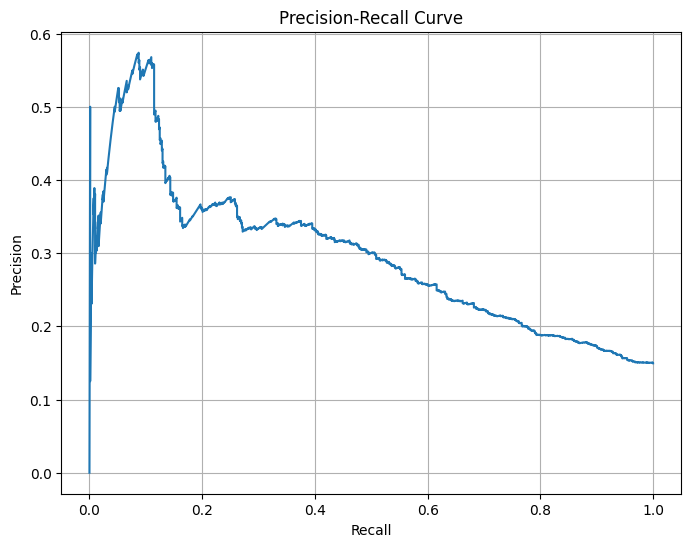

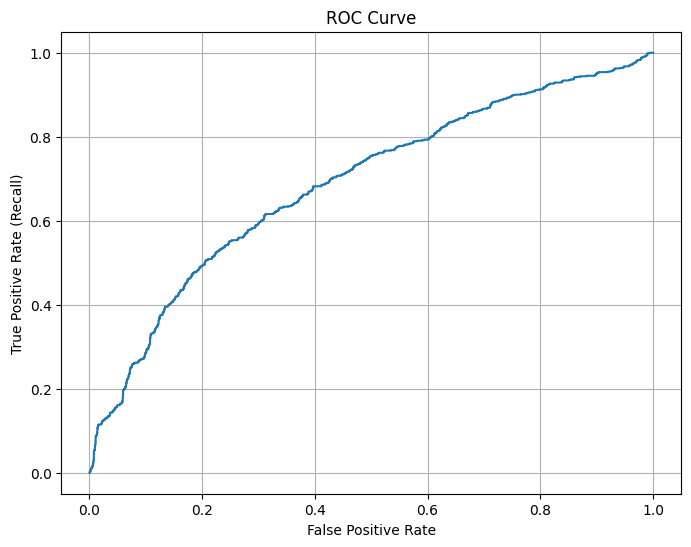

In [214]:
df = pd.DataFrame(data)
# Plot PR curve
plt.figure(figsize=(8, 6))
plt.plot(df['recall'], df['precision'], marker='')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()


plt.figure(figsize=(8, 6))
plt.plot(df['fpr'], df['recall'], marker='')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.grid(True)
plt.show()


In [261]:
thr = 0.05
network['predicted'] = network['padj_shift'].apply(lambda x: 1 if x < thr else 0)
network

,source,target,r_0,padj_0,r_14,padj_14,r,padj_r,shift,padj_shift,label,predicted
0,15901,12575,0.678279,0.037768,0.503406,0.210962,0.117519,0.626778,0.473324,0.000000,0,1
1,12387,22160,0.687687,0.037768,0.633473,0.135506,0.097633,0.684056,0.562947,0.000000,1,1
2,12387,22402,0.394179,0.203008,0.674375,0.134227,0.055078,0.815568,0.479199,0.000000,0,1
3,15900,18173,0.680593,0.037768,0.485354,0.227679,0.194109,0.426999,0.388864,0.000000,0,1
4,12387,22417,0.689741,0.037768,0.644985,0.134227,0.211685,0.384991,0.455678,0.000000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5359,20665,13363,0.683311,0.037768,0.543230,0.179895,0.635683,0.004255,-0.022412,0.999255,0,0
5360,17127,76399,0.641735,0.040008,0.682420,0.134227,0.684636,0.002827,-0.022559,0.999349,0,0
5361,20375,17533,0.626922,0.043100,0.686370,0.134227,0.679189,0.002827,-0.022543,0.999383,0,0
5362,328572,12895,0.688348,0.037768,0.628620,0.136628,0.681005,0.002827,-0.022521,0.999410,0,0


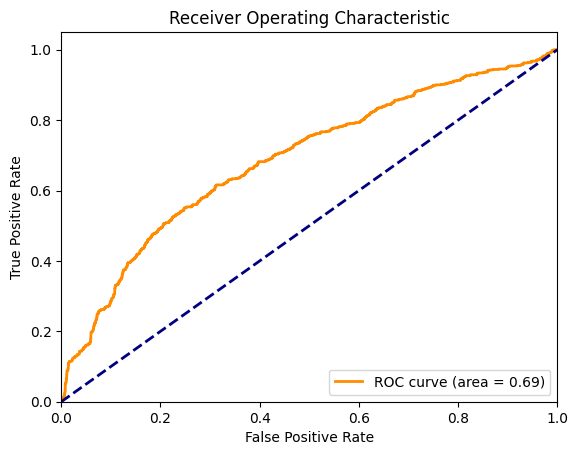

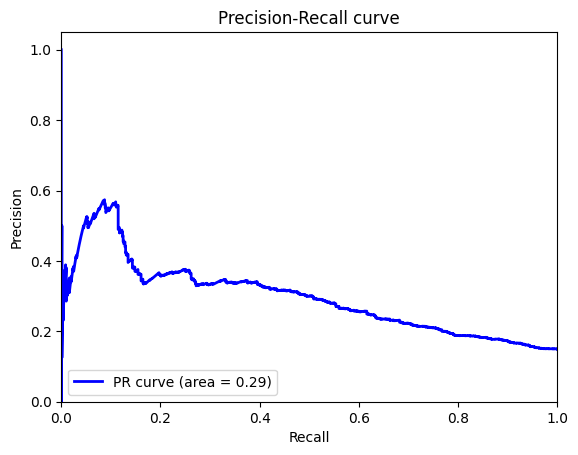

In [288]:
network = pd.read_csv("/Users/fernando/Documents/Research/DraCooN/evaluation/real_data/Tanja_Hussein/DN/DR/dn_bg_respadj_t0vs14_entropy_background_shift.tsv", sep='\t')
network = network.sort_values(by=['padj_shift'], ascending=True)

network['label'] = ((network['source'].astype(str).isin(ossification_geneset)) | (network['target'].astype(str).isin(ossification_geneset))).astype(int)
#network['label'] =  1 - network['label']

#network = network[network['padj_shift'] < thr]

network.reset_index(drop=True, inplace=True)

labels = network.label
ranks = -network.index

# Calculate the necessary values for ROC
fpr, tpr, _ = roc_curve(labels, ranks)
roc_auc = auc(fpr, tpr)

# Calculate the necessary values for PR curve
precision, recall, _ = precision_recall_curve(labels, ranks)
pr_auc = auc(recall, precision)  # Note the order: recall, precision


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.show()


###  Assessing all networks

In [289]:
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt

# define your directory
directory = '/Users/fernando/Documents/Research/DraCooN/evaluation/real_data/Tanja_Hussein/DN/DR/'

# join the path and the pattern
pattern = os.path.join(directory, "dn_bg_respadj_*")

# use glob to get all the files
file_list = glob.glob(pattern)

thr = 0.1
networks = {}
# print the list of files
for file in file_list:
    netname = file.split("/")[-1].replace("dn_bg_respadj_", "").replace(".tsv", "")
    df = pd.read_csv(file, sep="\t")

    # Check if both columns exist
    if "padj_absdiff" in df.columns and "padj_shift" in df.columns:
        # Sort by both columns
        # df = df[(df['padj_absdiff'] < thr) | (df['padj_shift'] < thr)]
        df_sorted = df.sort_values(by=["padj_absdiff", "padj_shift"])

    elif "padj_absdiff" in df.columns:
        # Sort by "padj_absdiff" only
        # df = df[df['padj_absdiff'] < thr]
        df_sorted = df.sort_values(by="padj_absdiff")

    elif "padj_shift" in df.columns:
        # Sort by "padj_shift" only
        # df = df[df['padj_shift'] < thr]
        df_sorted = df.sort_values(by="padj_shift")

    else:
        print("Both columns are missing in the dataframe")
       
    df_sorted['label'] = ((df_sorted['source'].astype(str).isin(ossification_geneset)) | (df_sorted['target'].astype(str).isin(ossification_geneset))).astype(int)
    # df_sorted['label'] =  1 - df_sorted['label']
    df_sorted.reset_index(drop=True, inplace=True)
    networks[netname] = df_sorted 




In [290]:
# Initialize an empty list to store each row as a dictionary
data = []

for key, value in networks.items():
    try: 
        labels = value.label
        ranks = -value.index

        # Calculate the necessary values for ROC
        fpr, tpr, _ = roc_curve(labels, ranks)
        roc_auc = auc(fpr, tpr)

        # Calculate the necessary values for PR curve
        precision, recall, _ = precision_recall_curve(labels, ranks)
        pr_auc = auc(recall, precision)  # Note the order: recall, precision

        # Append the results as a dictionary to the list
        data.append({'network': key, 'AUROC': roc_auc, 'AUPR': pr_auc, 'fpr':fpr, 'tpr': tpr,  'precision':precision, 'recall':recall})
    except: 
        data.append({'network': key, 'AUROC': 0, 'AUPR': 0, 'fpr':[], 'tpr': [],  'precision':[], 'recall':[]})
# Convert the list of dictionaries to a DataFrame
df_results = pd.DataFrame(data)

def modify_string(s):
    if s.count('_') == 2:
        base, ext = os.path.splitext(s)
        return f"{base}_both{ext}"
    else:
        return s

df_results['network'] = df_results['network'].apply(modify_string)
df_results[['time', 'assoc_metric', 'backgroundtype', 'diff_metric']] = df_results['network'].str.split('_', expand=True)

# Group by 'assoc_metric' and then sort by 'AUROC' in descending order
df_sorted = df_results.sort_values(['time', 'AUROC'], ascending=False)

#### AUROC

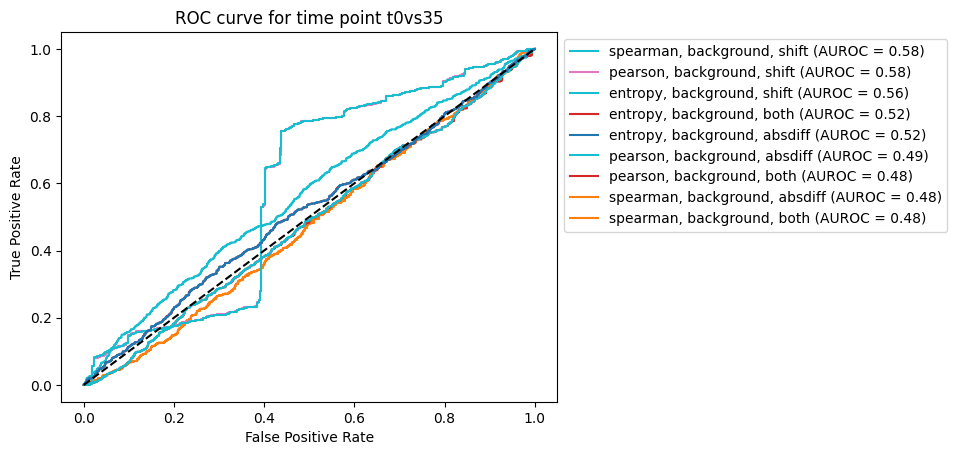

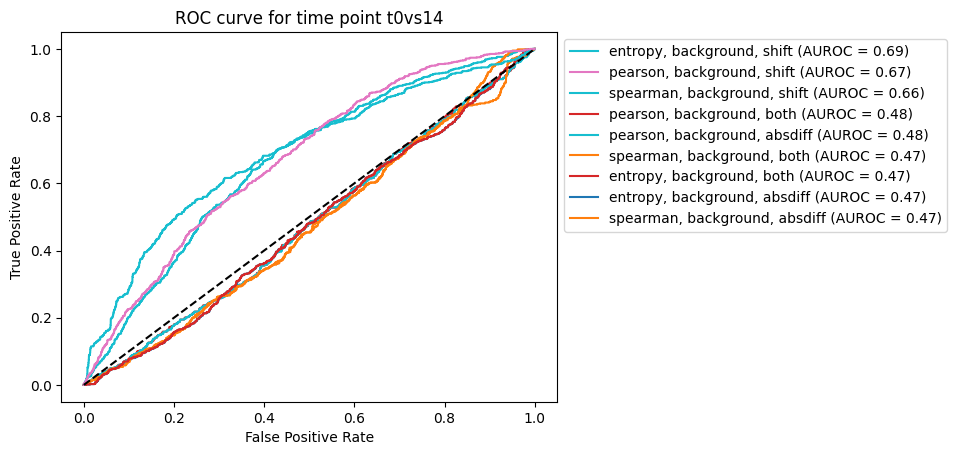

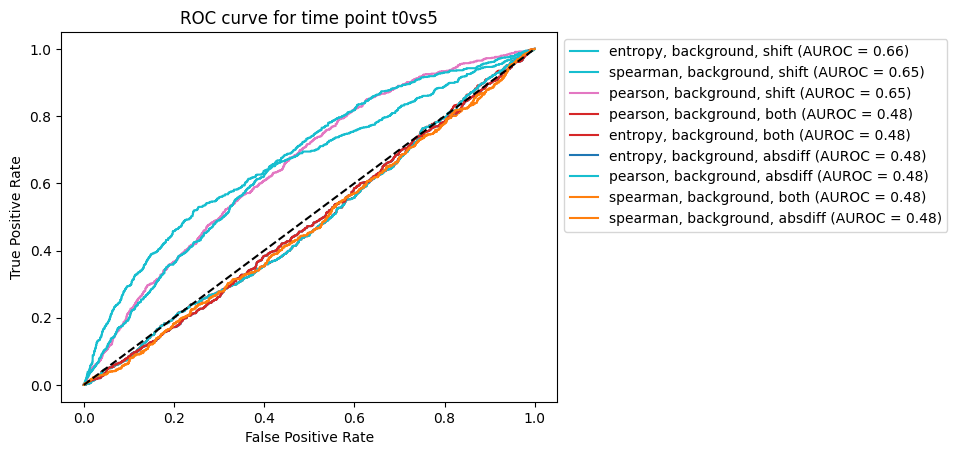

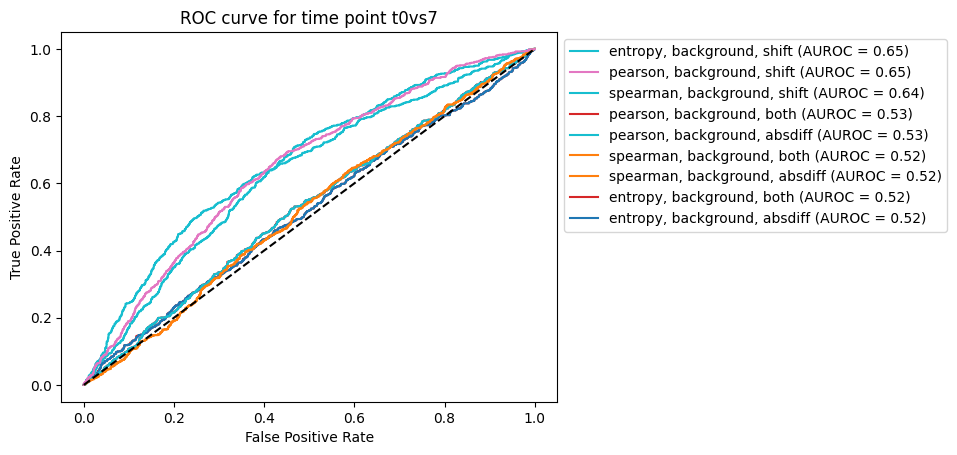

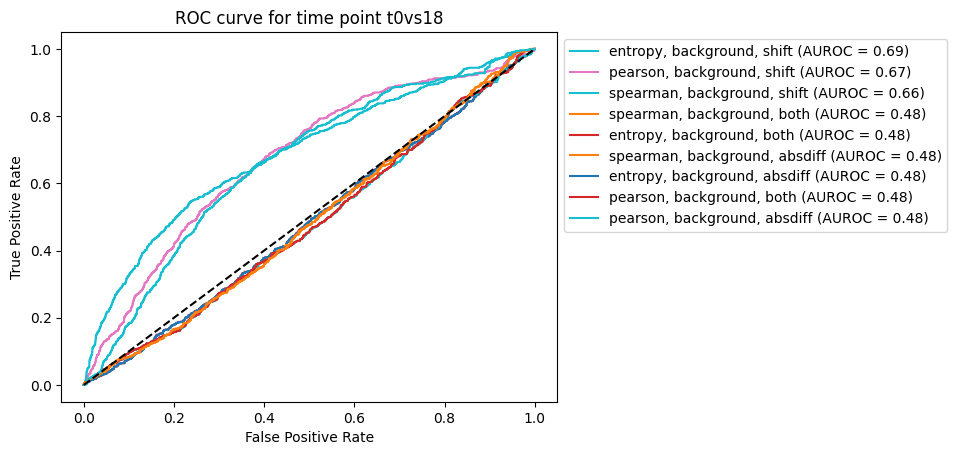

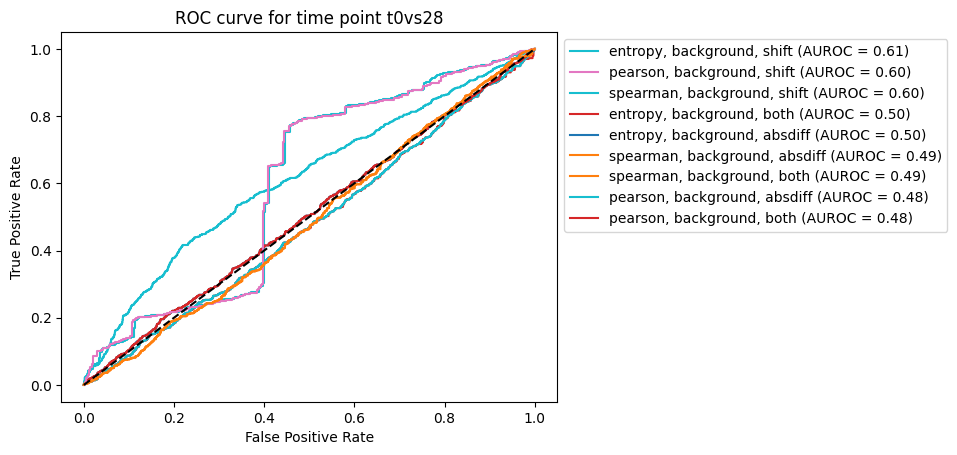

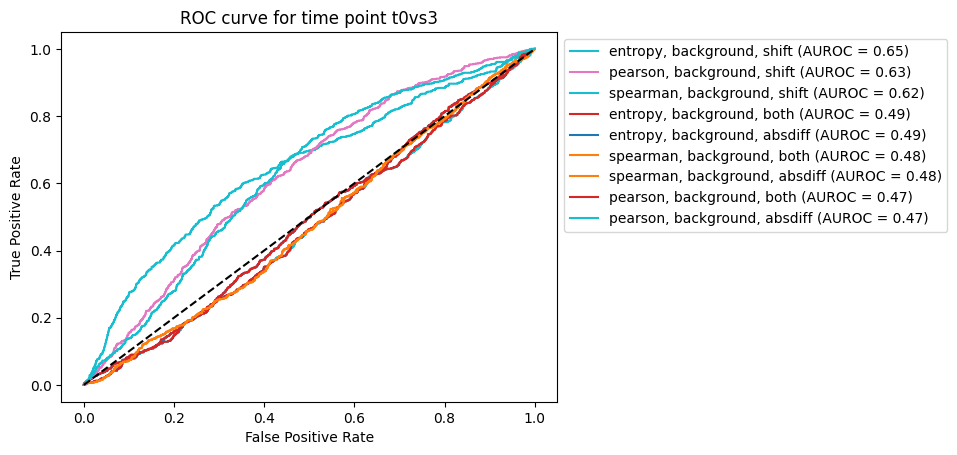

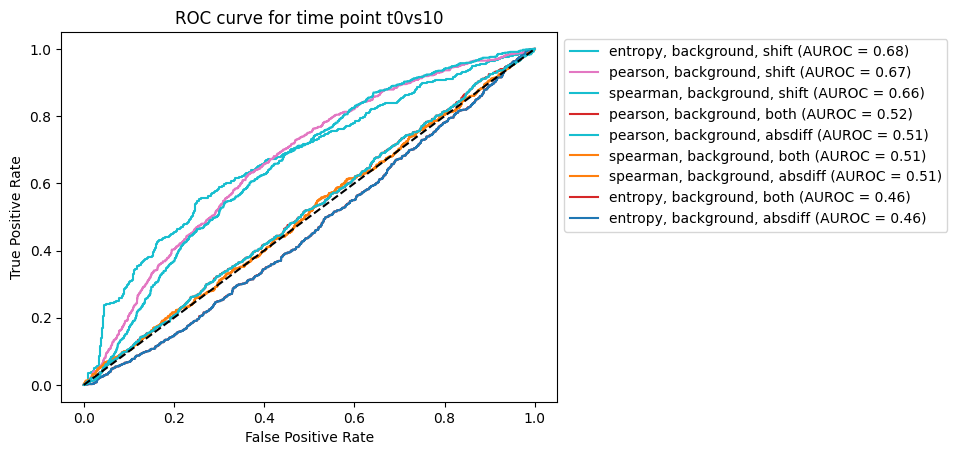

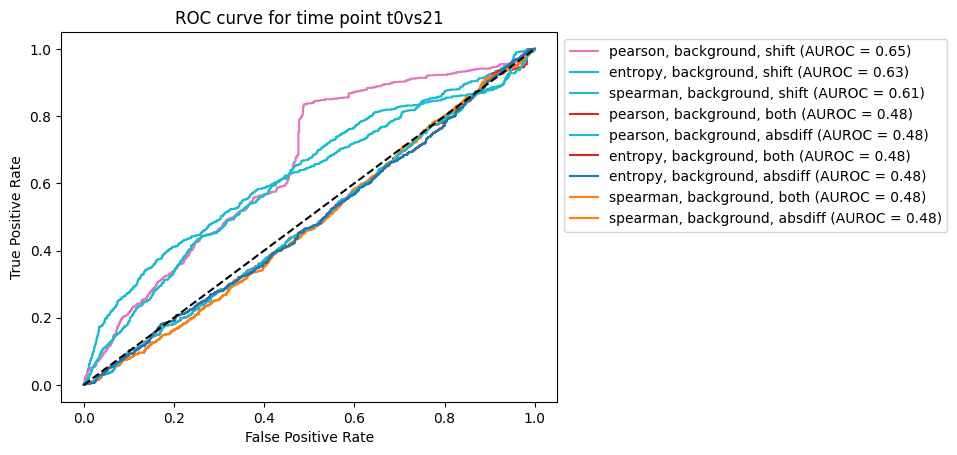

In [299]:
output_folder = '/Users/fernando/Documents/Research/DraCooN/evaluation/real_data/Tanja_Hussein/images/'

# Get unique time points
unique_time_points = df_results['time'].drop_duplicates().values

# Define color map for combinations
colormap = plt.colormaps['tab10']  # or any other colormap you like, e.g., 'tab10', 'viridis', etc.

# Get unique combinations
unique_combinations = df_results.drop_duplicates(subset=['assoc_metric', 'backgroundtype', 'diff_metric'])

combination_colors = {}
for idx, row in unique_combinations.iterrows():
    combination = (row['assoc_metric'], row['backgroundtype'], row['diff_metric'])
    normalized_index = idx / len(unique_combinations)  # normalize index to range [0, 1]
    combination_colors[combination] = colormap(normalized_index)

# Iterate through unique time points
for time_point in unique_time_points:
    # Filter DataFrame for the current time point
    df_filtered = df_results[df_results['time'] == time_point]

    # Plot ROC curve
    plt.figure()

    lines_labels = []  # Store lines, labels and AUROC here

    for _, row in df_filtered.iterrows():
        if row['backgroundtype'] == 'fittedbackground':
            pass
        else:
            label = f"{row['assoc_metric']}, {row['backgroundtype']}, {row['diff_metric']} (AUROC = {row['AUROC']:.2f})"
            combination = (row['assoc_metric'], row['backgroundtype'], row['diff_metric'])
            line, = plt.plot(row['fpr'], row['tpr'], color=combination_colors[combination])  # Store the line object
            lines_labels.append((line, label, row['AUROC']))

    # Sort lines_labels based on AUROC
    lines_labels.sort(key=lambda x: x[2], reverse=True)

    lines, labels, _ = zip(*lines_labels)

    plt.plot([0, 1], [0, 1], 'k--', label='chance level (AUROC = 0.5)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"ROC curve for time point {time_point}")

    # Add legend
    plt.legend(lines, labels, loc='upper left', bbox_to_anchor=(1, 1))  # Place the legend outside the plot to the right
    plt.show()
    # Save the plot to a file
    # output_file = os.path.join(output_folder, f"ROC_{time_point}.png") # change to your preferred file format if necessary
    # plt.savefig(output_file, dpi=300)

    #plt.close()  # close the figure after saving to free up memory


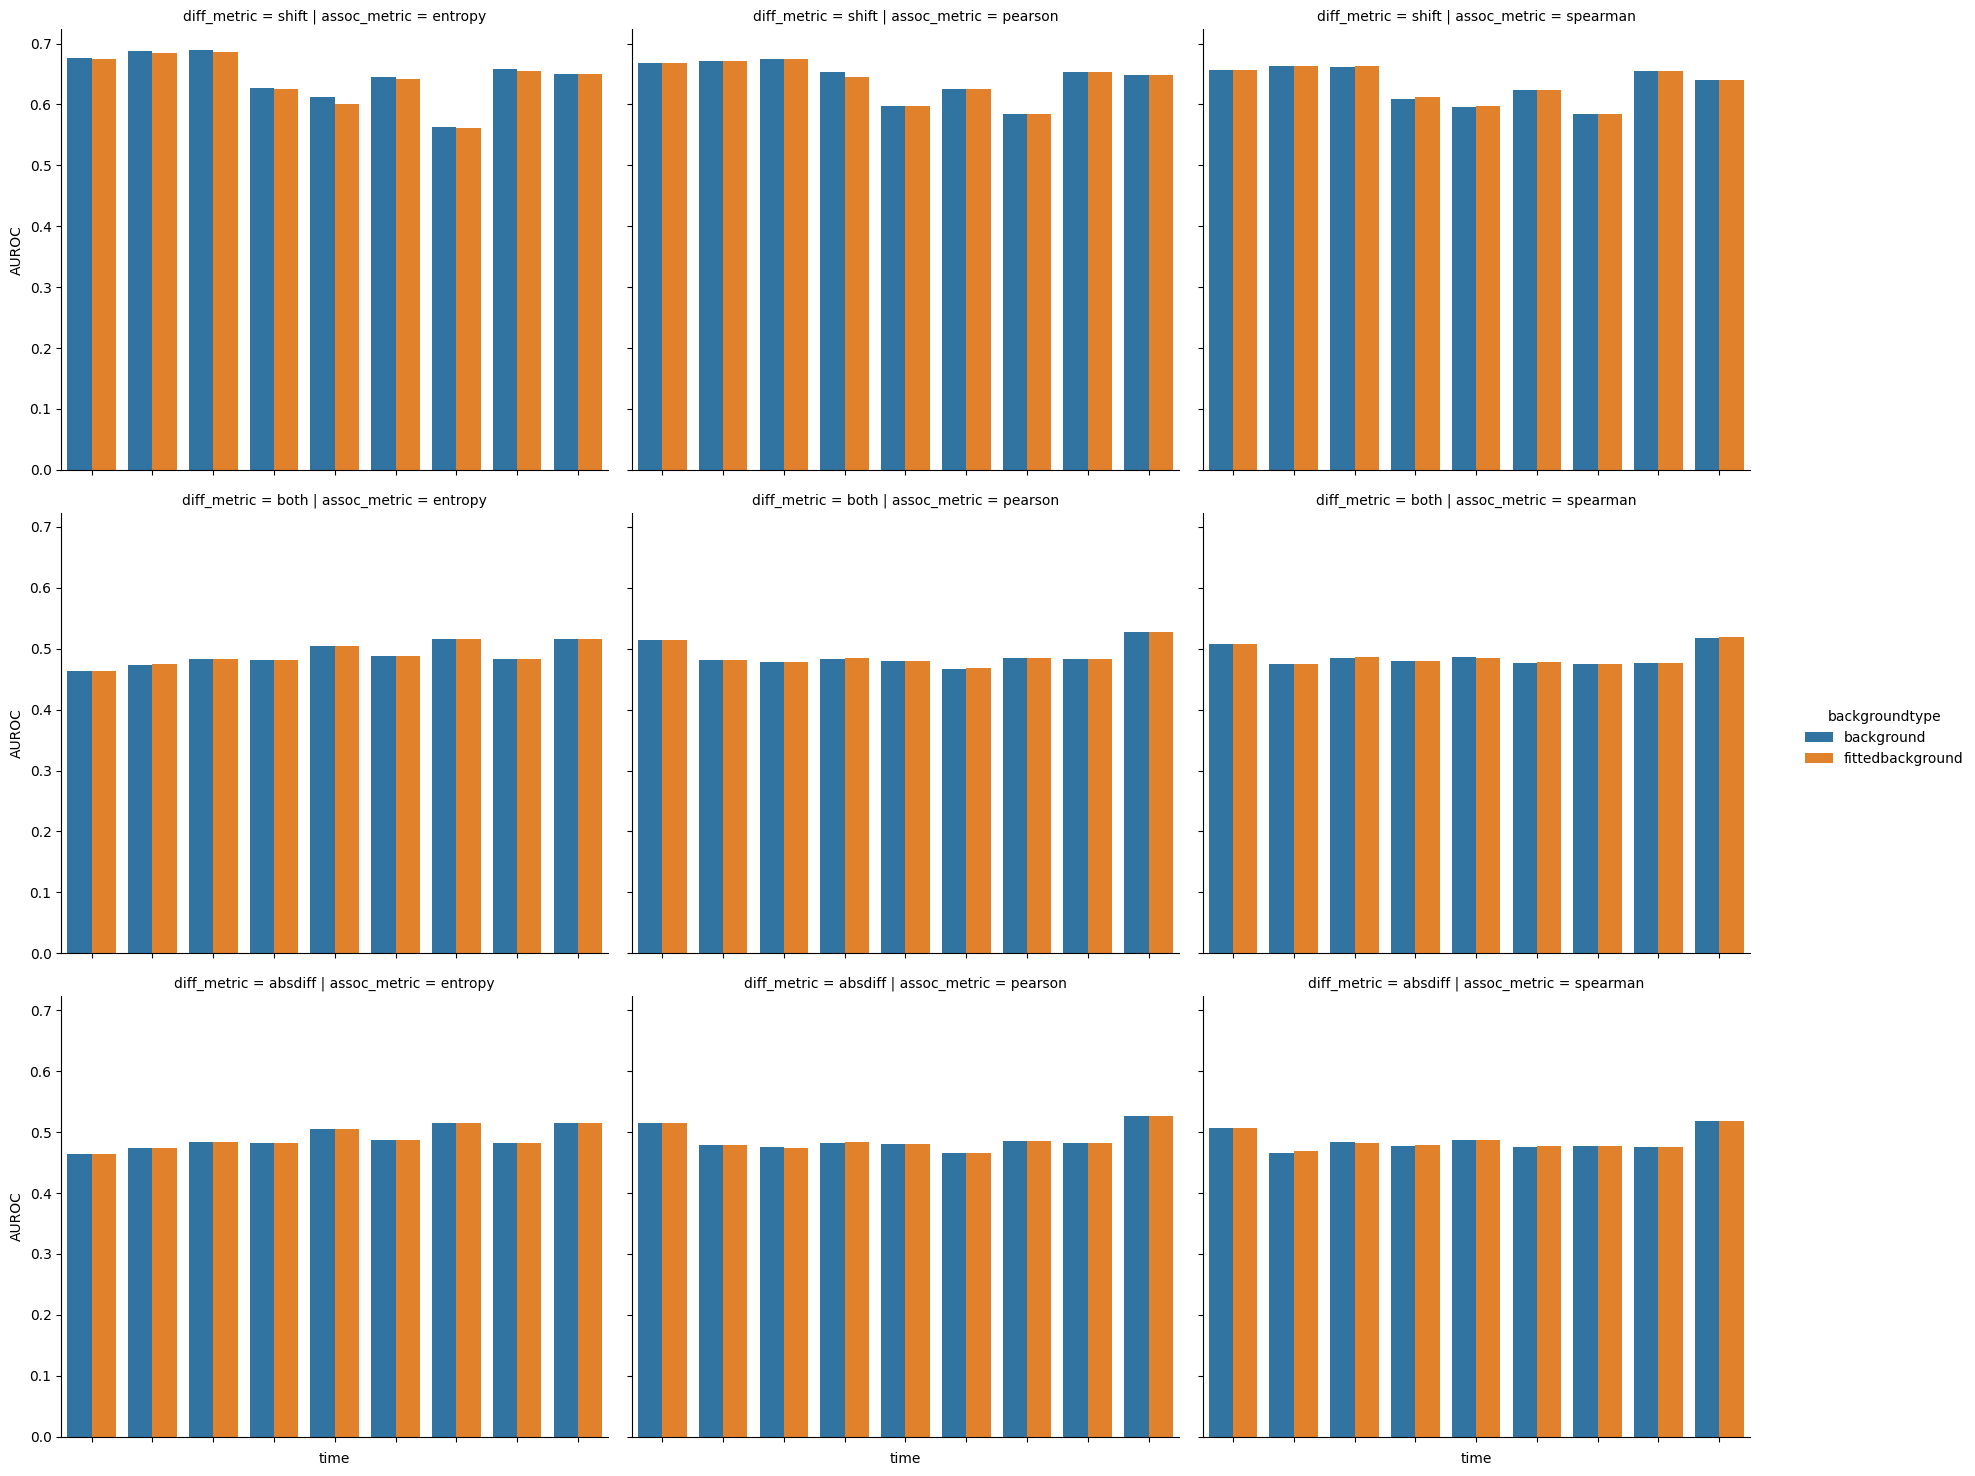

In [293]:
# Ensure 'time' is treated as a categorical variable
df_sorted['time'] = df_sorted['time'].astype('category')

# Create a catplot
g = sns.catplot(x='time', y='AUROC', hue='backgroundtype', col='assoc_metric', row='diff_metric', 
                data=df_sorted, kind='bar', errorbar='sd') # Here, 'sd' stands for standard deviation

# Rotate x-axis labels for readability
g.set_xticklabels(rotation=90)

# Adjust the height and aspect ratio of the plots to your liking
g.fig.set_figheight(15)
g.fig.set_figwidth(20)

plt.show()


In [294]:
# Group by the combination of 'assoc_metric', 'backgroundtype', 'diff_metric'
grouped = df_sorted.groupby(['assoc_metric', 'backgroundtype', 'diff_metric'])

# Calculate the mean 'AUROC' within each group
mean_auroc = grouped['AUROC'].mean()

# Sort by mean 'AUROC' in descending order
mean_auroc_sorted = mean_auroc.sort_values(ascending=False)
print(mean_auroc_sorted)
# Get the combination with the highest mean 'AUROC'
best_combination = mean_auroc_sorted.idxmax()

print(f"Best performing combination: {best_combination}")
print(f"Average AUROC: {mean_auroc_sorted.max()}")


assoc_metric  backgroundtype    diff_metric
entropy       background        shift          0.645596
              fittedbackground  shift          0.642308
pearson       background        shift          0.641780
              fittedbackground  shift          0.640754
spearman      fittedbackground  shift          0.632733
              background        shift          0.632157
entropy       fittedbackground  both           0.489998
              background        both           0.489921
              fittedbackground  absdiff        0.489765
              background        absdiff        0.489765
pearson       fittedbackground  both           0.489065
              background        both           0.488785
                                absdiff        0.488113
              fittedbackground  absdiff        0.487895
spearman      fittedbackground  both           0.486671
              background        both           0.486610
              fittedbackground  absdiff        0.485711
    

In [277]:
df_sorted['combination'] = df_sorted['assoc_metric'] +"_"+ df_sorted['backgroundtype'] +"_"+ df_sorted['diff_metric']


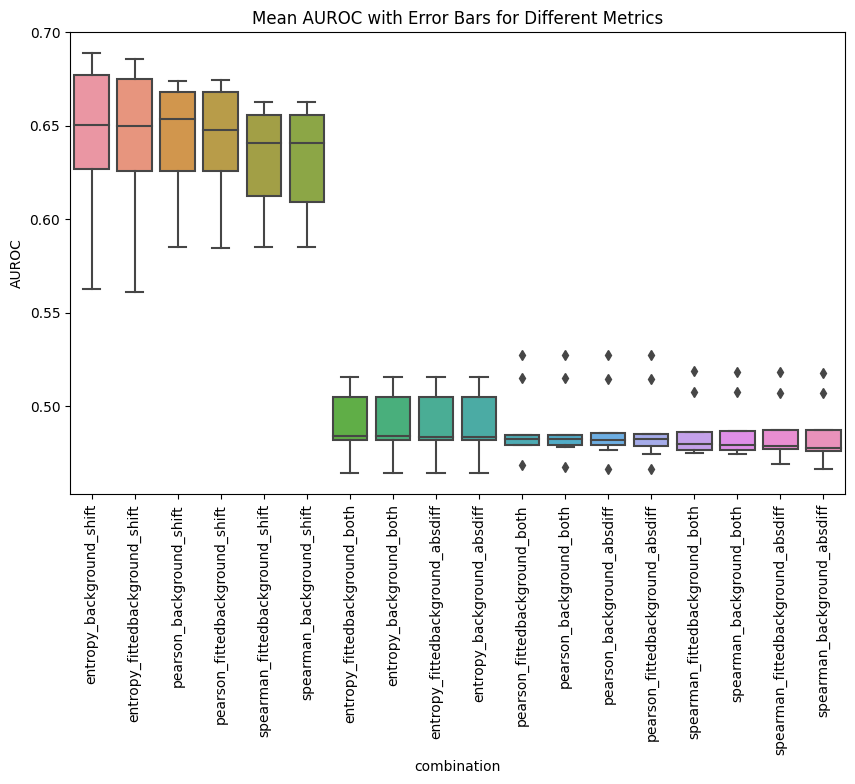

In [295]:
df_sorted['combination'] = df_sorted['assoc_metric'] +"_"+ df_sorted['backgroundtype'] +"_"+ df_sorted['diff_metric']


# Calculate the mean AUROC for each combination
mean_auroc = df_sorted.groupby('combination')['AUROC'].mean().reset_index()

# Sort the dataframe by mean AUROC in descending order
mean_auroc_sorted = mean_auroc.sort_values(by='AUROC', ascending=False)

# Plot the boxplot with sorted data
plt.figure(figsize=(10, 6))
sns.boxplot(x='combination', y='AUROC', data=df_sorted, order=mean_auroc_sorted['combination'])
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.title("Mean AUROC with Error Bars for Different Metrics")
plt.show()


(5364, 18)


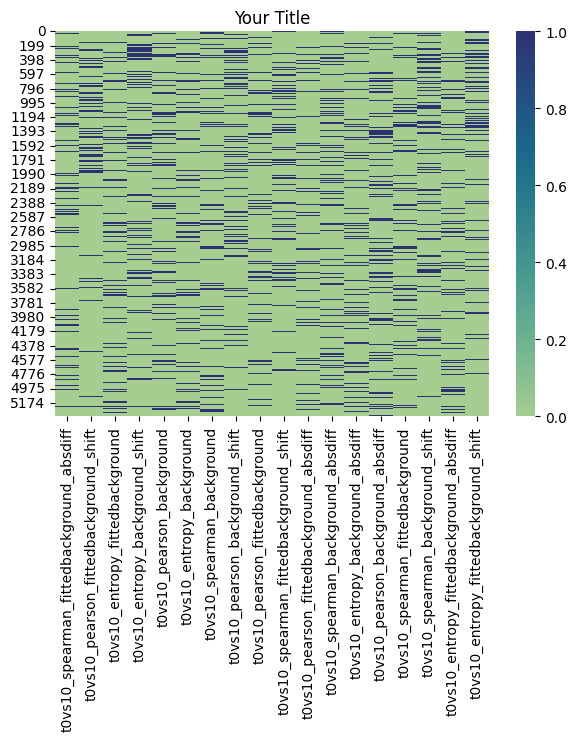

In [296]:

df_data = {}
for key, value in networks.items():
    
    if "t0vs10" in key:
        df_data[key] = value.label
    
df_data =  pd.DataFrame(df_data)  
import seaborn as sns
import matplotlib.pyplot as plt

print(df_data.shape)

# Create a heatmap
plt.figure(figsize=(7, 5))  # Set the size of your figure, customize for your requirement
sns.heatmap(df_data, cmap="crest", cbar=True)  # 'coolwarm' is the color map, cbar=True displays the color bar on the side

plt.title('Your Title')  # Set the title of your heatmap
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.yticks(rotation=0)   # Rotate y-axis labels for readability
plt.show()


#### AUPR

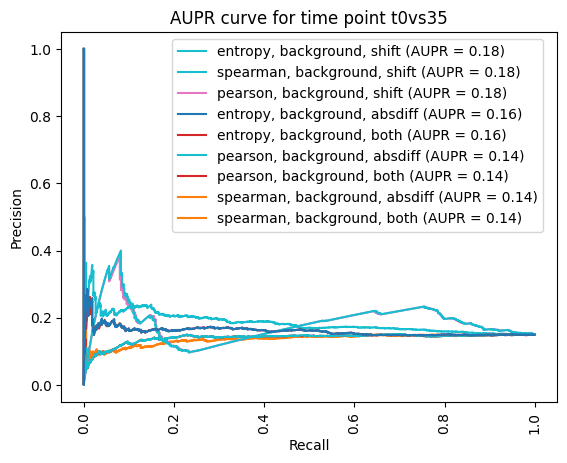

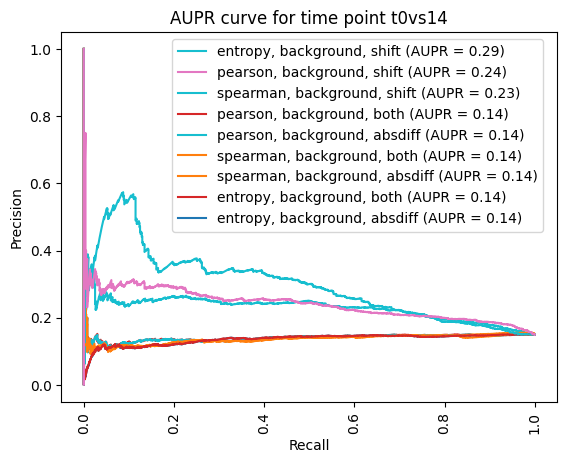

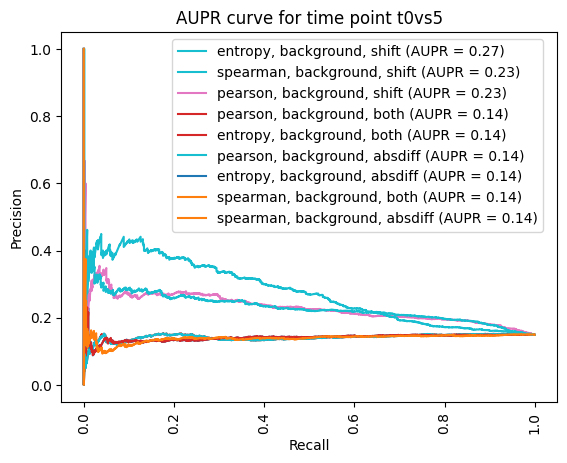

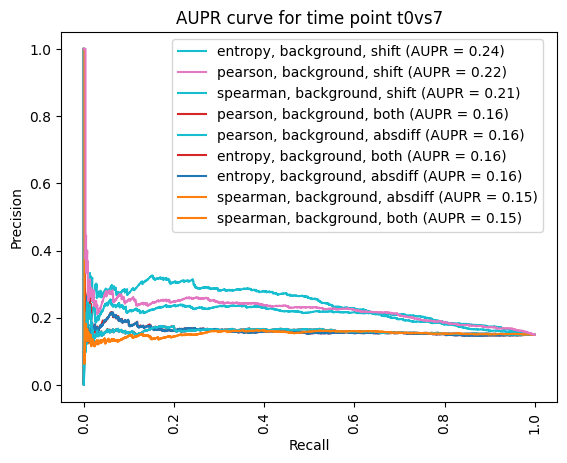

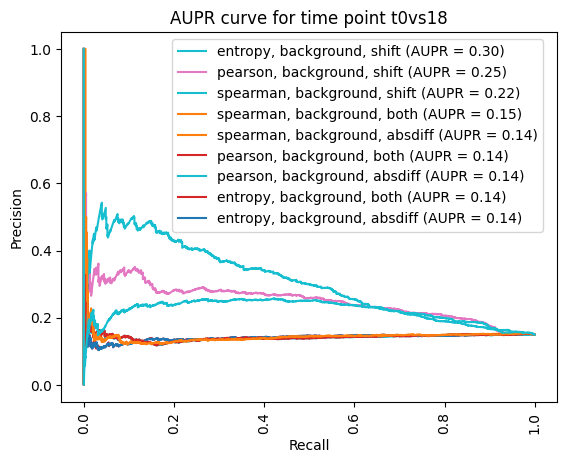

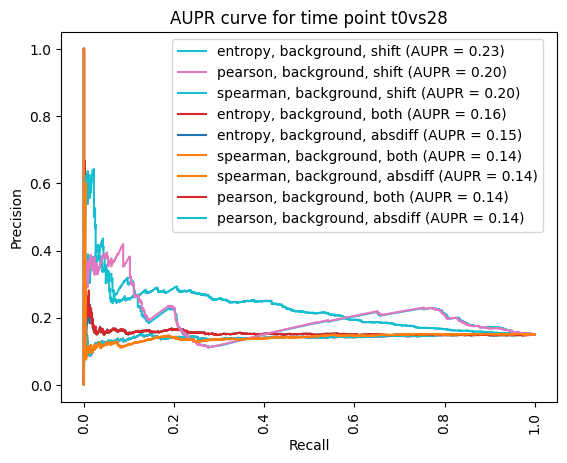

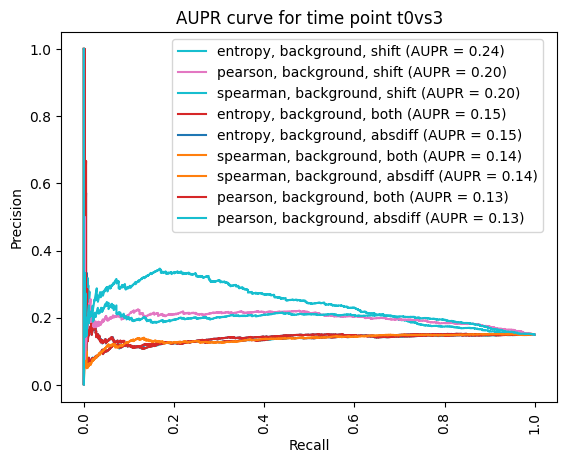

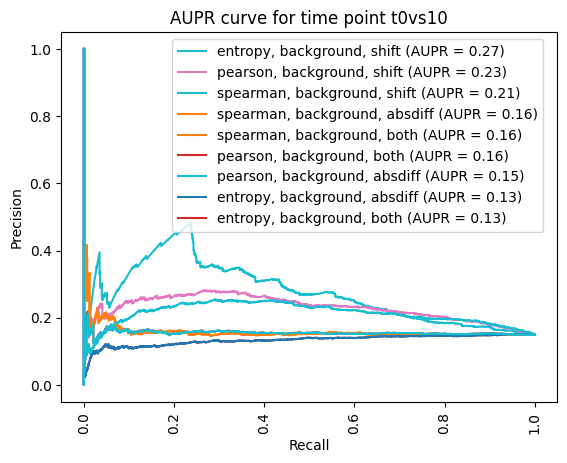

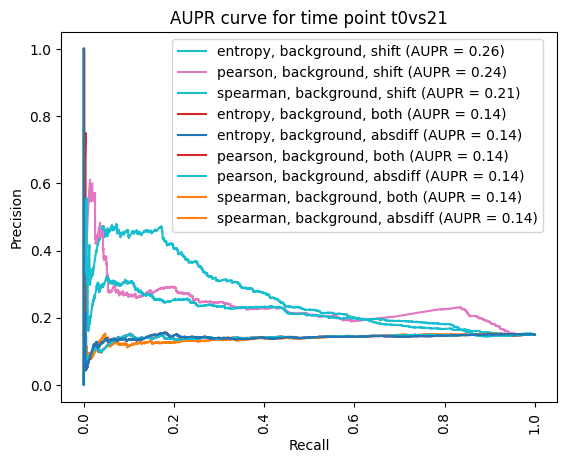

In [307]:
import os

output_folder = '/Users/fernando/Documents/Research/DraCooN/evaluation/real_data/Tanja_Hussein/images/'

# Get unique time points
unique_time_points = df_results['time'].drop_duplicates().values

# Define color map for combinations
colormap = plt.cm.tab10  # or any other colormap you like, e.g., 'tab10', 'viridis', etc.

# Get unique combinations
unique_combinations = df_results.drop_duplicates(subset=['assoc_metric', 'backgroundtype', 'diff_metric'])

combination_colors = {}
for idx, row in unique_combinations.iterrows():
    combination = (row['assoc_metric'], row['backgroundtype'], row['diff_metric'])
    normalized_index = idx / len(unique_combinations)  # normalize index to range [0, 1]
    combination_colors[combination] = colormap(normalized_index)

# Iterate through unique time points
for time_point in unique_time_points:
    # Filter DataFrame for the current time point
    df_filtered = df_results[df_results['time'] == time_point]

    # Plot AUPR curve
    plt.figure()

    lines_labels = []  # Store lines, labels, and AUPR here

    for _, row in df_filtered.iterrows():
        if row['backgroundtype'] == 'fittedbackground':
            pass
        else:
            label = f"{row['assoc_metric']}, {row['backgroundtype']}, {row['diff_metric']} (AUPR = {row['AUPR']:.2f})"
            combination = (row['assoc_metric'], row['backgroundtype'], row['diff_metric'])
            line, = plt.plot(row['recall'], row['precision'], color=combination_colors[combination])  # Store the line object
            lines_labels.append((line, label, row['AUPR']))

    # Sort lines_labels based on AUPR
    lines_labels.sort(key=lambda x: x[2], reverse=True)

    lines, labels, _ = zip(*lines_labels)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f"AUPR curve for time point {time_point}")

    # Add legend
    plt.legend(lines, labels, loc='upper left', bbox_to_anchor=(0.21, 1))  # Place the legend outside the plot to the right
    
    # Rotate x-axis labels for readability
    plt.xticks(rotation=90)
    plt.show()

    # Save the plot to a file
    # output_file = os.path.join(output_folder, f"AUPR_{time_point}.png")  # change to your preferred file format if necessary
    # plt.savefig(output_file, dpi=300)

    plt.close()  # close the figure after saving to free up memory


## Ossification GO terms retrieval

In [65]:
import requests

# URL of the GO OBO file
url = "http://purl.obolibrary.org/obo/go/go-basic.obo"

# Send a GET request to the URL
response = requests.get(url)

# Check that the request was successful
if response.status_code == 200:
    # Write the content of the response to a file
    with open("go-basic.obo", "w") as f:
        f.write(response.text)
else:
    print(f"Failed to download file: {response.status_code}, {response.reason}")


In [70]:
from Bio import Entrez
from goatools import obo_parser

# Always tell NCBI who you are
Entrez.email = "ferdecha@hotmail.es"

# Search the Gene database for "bone healing"
handle = Entrez.esearch(db="gene", term="bone healing")
record = Entrez.read(handle)

# Get the IDs of the genes related to bone healing
gene_ids = record["IdList"]
print(f"bone healing genes: {len(gene_ids)}")
# Load the GO obo file
go_db = obo_parser.GODag("go-basic.obo")

# For each gene, find associated GO terms (this is a placeholder, the actual method may be different)
for gene_id in gene_ids:
    handle = Entrez.efetch(db="gene", id=gene_id, rettype="gb", retmode="xml")
    gene_record = Entrez.read(handle)
    
    # This is a placeholder, the actual method of finding GO terms from a gene record may be different
    go_terms = get_go_terms(gene_record)
    
    for go_term in go_terms:
        print(go_db[go_term].name)


bone healing genes: 20
go-basic.obo: fmt(1.2) rel(2023-06-11) 46,420 Terms


NameError: name 'get_go_terms' is not defined

### Ossification GO children retrieval in the networks

In [104]:
%%R -i network

library(purrr)
library(clusterProfiler)
library(org.Mm.eg.db)
library(dplyr)
library(progress)

get_go_terms_from_network<- function(network){
    g <- graph_from_data_frame(network[,c('source', 'target')], directed=FALSE)
    #visNetwork::visIgraph(g)

    genes <- V(g)$name
    genes = sort(genes, decreasing = TRUE)
    #print(genes)
    # print('enriching')
    go_enrich <- enrichGO(gene = genes,
                        universe = gene_universe,
                        OrgDb =  "org.Mm.eg.db", 
                        keyType = 'ENTREZID',
                        readable = T,
                        ont = "BP",
                        pAdjustMethod = 'fdr',
                        pvalueCutoff = 0.01, 
                        qvalueCutoff = 0.01)
    resint <- data.frame(go_enrich)
    return(resint)
}
# Load your network dataframe
network <- read.csv("DN/DR/dn_bg_respadj_t0vs21_entropy_background.tsv", sep='\t')
network <- network %>% 
  arrange(padj_absdiff, padj_shift)
print(head(network))

  source target        r_0     padj_0       r_21    padj_21         r
1  12393 208098 0.67940034 0.03776756 0.09806146 0.75444796 0.1010522
2  56458  16197 0.08681674 0.78333626 0.67073751 0.03545343 0.6480238
3  13395  17869 0.15586867 0.61895476 0.68825142 0.03545343 0.2760571
4  13395  16009 0.69077990 0.03776756 0.14332397 0.64510650 0.2950791
5  13654  16185 0.11339339 0.71773053 0.65635387 0.03618638 0.5719362
6  19696  16176 0.17457095 0.57645756 0.69311641 0.03545343 0.3464098
        padj_r   absdiff padj_absdiff       shift  padj_shift           sig
1 0.6285679090 0.5813389            0  0.28767869 0.001402367 absdiff_shift
2 0.0008832762 0.5839208            0 -0.26924664 0.007857205 absdiff_shift
3 0.1810327256 0.5323827            0  0.14600295 0.031613522 absdiff_shift
4 0.1520218666 0.5474559            0  0.12197284 0.053527371 absdiff_shift
5 0.0036470299 0.5429605            0 -0.18706257 0.053866391 absdiff_shift
6 0.0911414405 0.5185455            0  0.08743388 0.11

In [107]:
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.packages import importr

# Enable automatic conversion from pandas to R
pandas2ri.activate()

# Import R packages
igraph = importr('igraph')
clusterProfiler = importr('clusterProfiler')

# Define the R function
get_go_terms_from_network = r("""
function(network){
    g <- igraph::graph_from_data_frame(network[,c('source', 'target')], directed=FALSE)

    genes <- igraph::V(g)$name
    genes = sort(genes, decreasing = TRUE)

    go_enrich <- clusterProfiler::enrichGO(gene = genes,
                        OrgDb =  "org.Mm.eg.db", 
                        keyType = 'ENTREZID',
                        readable = T,
                        ont = "BP",
                        pAdjustMethod = 'fdr',
                        pvalueCutoff = 0.01, 
                        qvalueCutoff = 0.01)
    resint <- data.frame(go_enrich)
    return(resint)
}
""")

# Call the R function with a pandas DataFrame as argument
network = pd.DataFrame(...)  # replace with your DataFrame
result = get_go_terms_from_network(network)

# The result is now a pandas DataFrame
print(result)
print(


Attachement du package : ‘foreach’

Les objets suivants sont masqués depuis ‘package:purrr’:

    accumulate, when

Le chargement a nécessité le package : iterators
Le chargement a nécessité le package : parallel
Erreur dans e$fun(obj, substitute(ex), parent.frame(), e$data) : 
  worker initialization failed: aucun package nommé ‘your_required_packages’ n'est trouvé


RInterpreterError: Failed to parse and evaluate line "# Load necessary libraries\nlibrary(foreach)\nlibrary(doParallel)\n\n# Register the number of cores you want to use\nno_cores <- detectCores() - 1  # Leave one core free\ncl <- makeCluster(no_cores)\nregisterDoParallel(cl)\n\n# Initialize your lists\nsub_dfs <- list()\nsub_dfs_gos <- list()\n\n# Split your network dataframe into a list of dataframes (each containing a single row)\nnetwork_list <- split(network, seq_len(nrow(network)))\n\n# Use foreach to iterate over the list in parallel\nresults <- foreach(i = seq_along(network_list), .combine = 'c', .packages = 'your_required_packages') %dopar% {\n  sub_network <- network_list[[i]]\n  sub_dfs <- sub_network\n  sub_dfs_gos <- get_go_terms_from_network(sub_network)\n  list(sub_dfs, sub_dfs_gos)  # return both results as a list\n}\n\n# The results object is a list of lists, where each sublist contains the sub_dfs and sub_dfs_gos for each iteration\n\n# Stop the cluster after computation\nstopCluster(cl)\n".
R error message: "Erreur dans e$fun(obj, substitute(ex), parent.frame(), e$data) : \n  worker initialization failed: aucun package nommé ‘your_required_packages’ n'est trouvé"
R stdout:

Attachement du package : ‘foreach’

Les objets suivants sont masqués depuis ‘package:purrr’:

    accumulate, when

Le chargement a nécessité le package : iterators
Le chargement a nécessité le package : parallel
Erreur dans e$fun(obj, substitute(ex), parent.frame(), e$data) : 
  worker initialization failed: aucun package nommé ‘your_required_packages’ n'est trouvé

In [ ]:
%%R
# Load required libraries
library(doParallel)
library(foreach)


# Load your network dataframe
network <- read.csv("DN/DR/dn_bg_respadj_t0vs21_entropy_background.tsv", sep='\t')
network <- network %>% 
  arrange(padj_absdiff, padj_shift)
print(head(network))

network <- head(network, 10)


# Determine the number of cores to use for parallel processing
no_cores <- detectCores() - 1 

# Register the parallel backend
registerDoParallel(cores=no_cores)

# Create a list of dataframes
network_list <- replicate(nrow(network), network, simplify = FALSE)

# Initialize your lists
sub_dfs <- list()
sub_dfs_gos <- list()

# Iterate through the DataFrame in parallel
results <- foreach(i = seq_along(network_list), .packages = c('clusterProfiler', 'org.Mm.eg.db')) %dopar% {
    # Get the current network
    curr_network <- network_list[[i]]
    
    # Remove the last row
    curr_network <- curr_network[-nrow(curr_network),]
    
    # Store the subset DataFrame in the dictionary
    sub_dfs[[length(sub_dfs) + 1]] <- curr_network
    sub_dfs_gos[[length(sub_dfs) + 1]] <- get_go_terms_from_network(curr_network)
}

# Stop the parallel backend
stopImplicitCluster()
